# eWRC Scraper

`ewrc-results.com` is a comprehensive rally results service.

Let's see if we can build a data downloader and generate some reports from their data...

Simple js API that filters on WRC...: https://github.com/nathanjliu/WRC-API

(For Tendring, there were also results at https://www.rallies.info/res.php?e=296 .)

In [1]:
import pandas as pd
import re
from dakar_utils import getTime

In [2]:
url= 'https://www.ewrc-results.com/final/54762-corbeau-seats-rally-tendring-clacton-2019/'

![](images/eWRC-final_results.png)

In [3]:
pd.read_html(url)[0].head()

,0,1,2,3,4,5,6,7,8,9
0,1.,#1,NaN,Preston Thomas - Williamson Carl,NaN,Škoda Fabia R5 (SP 05-41),E,50:50.2,NaN,101.8
1,2.,#4,NaN,O'Brien Michael - Glennerster Mark,NaN,Ford Focus RS WRC '07 (EA07 RGZ),E,50:55.8,+5.6 +5.6,101.6 0.06
2,3.,#26,NaN,Jones Craig - Taylor Ian,NaN,Mitsubishi Lancer Evo IX (PNZ 5336),E,52:27.2,+1:37.0 +1:31.4,98.7 1.12
3,4.,#44,NaN,Anderson Guy - Link Stephen,NaN,Mitsubishi Galant VR-4 (J14 MRE),H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83
4,5.,#8,NaN,Self James - Davis Ian,NaN,Ford Fiesta R5 (PX15 HYY),E,53:29.1,+2:38.9 +1.4,96.8 1.84


How do we get the nested HTML out?

*It would be nice if this issue around converters was addressed? https://github.com/pandas-dev/pandas/issues/14608 *



In [4]:
import requests

html = requests.get(url).text

In [5]:
#https://stackoverflow.com/a/31772009/454773
import lxml.html as LH
from bs4 import BeautifulSoup

soup = BeautifulSoup(html, 'lxml') # Parse the HTML as a string
    
tables = soup.find_all('table')
#tables = LH.fromstring(html).xpath('//table')
df_rally_overall = pd.read_html('<html><body>{}</body></html>'.format(tables[0]))[0]
df_rally_overall['badge'] = [img.find('img')['src'] for img in tables[0].findAll("td", {"class": "final-results-icon"}) ]
df_rally_overall.dropna(how='all', axis=1, inplace=True)
df_rally_overall.head()

,0,1,3,5,6,7,8,9,badge
0,1.,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5 (SP 05-41),E,50:50.2,NaN,101.8,/images/icon/skoda.png
1,2.,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '07 (EA07 RGZ),E,50:55.8,+5.6 +5.6,101.6 0.06,/images/icon/ford.png
2,3.,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX (PNZ 5336),E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,/images/icon/mitsu.png
3,4.,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4 (J14 MRE),H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,/images/icon/mitsu.png
4,5.,#8,Self James - Davis Ian,Ford Fiesta R5 (PX15 HYY),E,53:29.1,+2:38.9 +1.4,96.8 1.84,/images/icon/ford.png


In [6]:
df_rally_overall.columns=['Pos','CarNum','driverNav','ModelReg','Class', 'Time','GapDiff', 'Speedkm', 'badge']

In [7]:
#Get the entry ID - use this as the unique key
#in column 3, <a title='Entry info and stats'>
df_rally_overall['entryId']=[a['href'] for a in tables[0].findAll("a", {"title": "Entry info and stats"}) ]
df_rally_overall.set_index('entryId', inplace=True)
df_rally_overall.head()

,Pos,CarNum,driverNav,ModelReg,Class,Time,GapDiff,Speedkm,badge
entryId,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1.,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5 (SP 05-41),E,50:50.2,NaN,101.8,/images/icon/skoda.png
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2.,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '07 (EA07 RGZ),E,50:55.8,+5.6 +5.6,101.6 0.06,/images/icon/ford.png
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3.,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX (PNZ 5336),E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,/images/icon/mitsu.png
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4.,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4 (J14 MRE),H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,/images/icon/mitsu.png
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5.,#8,Self James - Davis Ian,Ford Fiesta R5 (PX15 HYY),E,53:29.1,+2:38.9 +1.4,96.8 1.84,/images/icon/ford.png


In [8]:
df_rally_overall[['Driver','CoDriver']] = df_rally_overall['driverNav'].str.extract(r'(?P<Driver>.*)\s+-\s+(?P<CoDriver>.*)')
df_rally_overall.head()

,Pos,CarNum,driverNav,ModelReg,Class,Time,GapDiff,Speedkm,badge,Driver,CoDriver
entryId,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1.,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5 (SP 05-41),E,50:50.2,NaN,101.8,/images/icon/skoda.png,Preston Thomas,Williamson Carl
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2.,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '07 (EA07 RGZ),E,50:55.8,+5.6 +5.6,101.6 0.06,/images/icon/ford.png,O'Brien Michael,Glennerster Mark
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3.,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX (PNZ 5336),E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,/images/icon/mitsu.png,Jones Craig,Taylor Ian
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4.,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4 (J14 MRE),H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,/images/icon/mitsu.png,Anderson Guy,Link Stephen
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5.,#8,Self James - Davis Ian,Ford Fiesta R5 (PX15 HYY),E,53:29.1,+2:38.9 +1.4,96.8 1.84,/images/icon/ford.png,Self James,Davis Ian


In [9]:
df_rally_overall['Historic']= df_rally_overall['Class'].str.contains('Historic')
df_rally_overall['Class']= df_rally_overall['Class'].str.replace('Historic','')
df_rally_overall['Class'].unique()

array(['E', 'H4b', 'D', 'C', 'H3', 'HK', 'B', 'A', 'H2', 'H1'],
      dtype=object)

In [10]:
df_rally_overall['Pos'] = df_rally_overall['Pos'].str.extract(r'(.*)\.')
df_rally_overall['Pos'] = df_rally_overall['Pos'].astype(int)
df_rally_overall.dtypes

Pos           int64
CarNum       object
driverNav    object
ModelReg     object
Class        object
Time         object
GapDiff      object
Speedkm      object
badge        object
Driver       object
CoDriver     object
Historic       bool
dtype: object

In [11]:
df_rally_overall[['Model','Registration']]=df_rally_overall['ModelReg'].str.extract(r'(?P<Model>.*) \((?P<Registration>.*)\)')
df_rally_overall.head()

,Pos,CarNum,driverNav,ModelReg,Class,Time,GapDiff,Speedkm,badge,Driver,CoDriver,Historic,Model,Registration
entryId,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5 (SP 05-41),E,50:50.2,NaN,101.8,/images/icon/skoda.png,Preston Thomas,Williamson Carl,False,Škoda Fabia R5,SP 05-41
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '07 (EA07 RGZ),E,50:55.8,+5.6 +5.6,101.6 0.06,/images/icon/ford.png,O'Brien Michael,Glennerster Mark,False,Ford Focus RS WRC '07,EA07 RGZ
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX (PNZ 5336),E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,/images/icon/mitsu.png,Jones Craig,Taylor Ian,False,Mitsubishi Lancer Evo IX,PNZ 5336
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4 (J14 MRE),H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,/images/icon/mitsu.png,Anderson Guy,Link Stephen,False,Mitsubishi Galant VR-4,J14 MRE
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5,#8,Self James - Davis Ian,Ford Fiesta R5 (PX15 HYY),E,53:29.1,+2:38.9 +1.4,96.8 1.84,/images/icon/ford.png,Self James,Davis Ian,False,Ford Fiesta R5,PX15 HYY


In [12]:
df_rally_overall.tail()

,Pos,CarNum,driverNav,ModelReg,Class,Time,GapDiff,Speedkm,badge,Driver,CoDriver,Historic,Model,Registration
entryId,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227182/,81,#124,Harrison Neil - Dockree Dave,Ford Puma (X926 SGF),A,1:11:03.3,+20:13.1 +10.3,72.9 14.06,/images/icon/ford.png,Harrison Neil,Dockree Dave,False,Ford Puma,X926 SGF
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227177/,82,#119,Beales Bob - Leflay Mike,Volkswagen Beetle (UWP 401),HK,1:16:03.20:10,+25:13.0 +4:59.9,68.1 17.54,/images/icon/vw.png,Beales Bob,Leflay Mike,False,Volkswagen Beetle,UWP 401
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2249931/,83,#135,Marshall Barrie - Hernden Tony,Nissan Micra (X207 PJN),A,1:22:28.41:00,+31:38.2 +6:25.2,62.8 22.00,/images/icon/nissan.png,Marshall Barrie,Hernden Tony,False,Nissan Micra,X207 PJN
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/,84,#75,May Simon - May Adrian,Ford Escort MK2 (NWM 295S),C,1:34:21.0,+43:30.8 +11:52.6,54.9 30.26,/images/icon/ford.png,May Simon,May Adrian,False,Ford Escort MK2,NWM 295S
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227145/,85,#93,Johnson Mick - Mactavish Jamie,Ford Puma (S103 ROB),A,1:47:56.9,+57:06.7 +13:35.9,48.0 39.72,/images/icon/ford.png,Johnson Mick,Mactavish Jamie,False,Ford Puma,S103 ROB


In [13]:
df_rally_overall["Class Rank"] = df_rally_overall.groupby("Class")["Pos"].rank(method='min')

df_rally_overall.head()

,Pos,CarNum,driverNav,ModelReg,Class,Time,GapDiff,Speedkm,badge,Driver,CoDriver,Historic,Model,Registration,Class Rank
entryId,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1,#1,Preston Thomas - Williamson Carl,Škoda Fabia R5 (SP 05-41),E,50:50.2,NaN,101.8,/images/icon/skoda.png,Preston Thomas,Williamson Carl,False,Škoda Fabia R5,SP 05-41,1.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2,#4,O'Brien Michael - Glennerster Mark,Ford Focus RS WRC '07 (EA07 RGZ),E,50:55.8,+5.6 +5.6,101.6 0.06,/images/icon/ford.png,O'Brien Michael,Glennerster Mark,False,Ford Focus RS WRC '07,EA07 RGZ,2.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3,#26,Jones Craig - Taylor Ian,Mitsubishi Lancer Evo IX (PNZ 5336),E,52:27.2,+1:37.0 +1:31.4,98.7 1.12,/images/icon/mitsu.png,Jones Craig,Taylor Ian,False,Mitsubishi Lancer Evo IX,PNZ 5336,3.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4,#44,Anderson Guy - Link Stephen,Mitsubishi Galant VR-4 (J14 MRE),H4b,53:27.7,+2:37.5 +1:00.5,96.8 1.83,/images/icon/mitsu.png,Anderson Guy,Link Stephen,False,Mitsubishi Galant VR-4,J14 MRE,1.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5,#8,Self James - Davis Ian,Ford Fiesta R5 (PX15 HYY),E,53:29.1,+2:38.9 +1.4,96.8 1.84,/images/icon/ford.png,Self James,Davis Ian,False,Ford Fiesta R5,PX15 HYY,4.0


In [14]:
df_rally_overall.tail()

,Pos,CarNum,driverNav,ModelReg,Class,Time,GapDiff,Speedkm,badge,Driver,CoDriver,Historic,Model,Registration,Class Rank
entryId,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227182/,81,#124,Harrison Neil - Dockree Dave,Ford Puma (X926 SGF),A,1:11:03.3,+20:13.1 +10.3,72.9 14.06,/images/icon/ford.png,Harrison Neil,Dockree Dave,False,Ford Puma,X926 SGF,8.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227177/,82,#119,Beales Bob - Leflay Mike,Volkswagen Beetle (UWP 401),HK,1:16:03.20:10,+25:13.0 +4:59.9,68.1 17.54,/images/icon/vw.png,Beales Bob,Leflay Mike,False,Volkswagen Beetle,UWP 401,4.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2249931/,83,#135,Marshall Barrie - Hernden Tony,Nissan Micra (X207 PJN),A,1:22:28.41:00,+31:38.2 +6:25.2,62.8 22.00,/images/icon/nissan.png,Marshall Barrie,Hernden Tony,False,Nissan Micra,X207 PJN,9.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227045/,84,#75,May Simon - May Adrian,Ford Escort MK2 (NWM 295S),C,1:34:21.0,+43:30.8 +11:52.6,54.9 30.26,/images/icon/ford.png,May Simon,May Adrian,False,Ford Escort MK2,NWM 295S,21.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227145/,85,#93,Johnson Mick - Mactavish Jamie,Ford Puma (S103 ROB),A,1:47:56.9,+57:06.7 +13:35.9,48.0 39.72,/images/icon/ford.png,Johnson Mick,Mactavish Jamie,False,Ford Puma,S103 ROB,10.0


In [15]:
#Car registration not a reliable match
_entries = pd.read_csv('corbeau19_entries_archive.csv')
_entries['Driver Reverse'] = _entries['Driver'].str.replace(r'(.+)\s+([^\s]+)$', r'\2 \1')
_entries.head()

,Class,Driver,Driver_Nationality,Driver_Town,Driver_Clubs,Co-driver,Co-driver_Nationality,Co-driver_Town,Co-driver_Clubs,Car,Details,Sponsor,CC,Colour,Registration,Year,Driver Reverse
0,E,Thomas Preston,British,Lancashire,PDMC / CMC,Carl Williamson,British,Bradford,BTRDA / CMC,Skoda Fabia R5,1600T ~ Black/Purple ~ SP0541 ~ 2018,Hippo Motor Group,1600T,Black/Purple,SP0541,2018,Preston Thomas
1,E,Robert Swann,English,Bishops Stortford,Wickford AC,Steve McNulty,British,Ilford,Chelmsford Motor Club,Mitsubishi Mirage,1598T ~ Yellow ~ GM65 OHJ ~ 2015,"Elegant Hotels, Blue Sky luxury, R.A.SWANN LTD",1598T,Yellow,GM65 OHJ,2015,Swann Robert
2,E,Michael O'Brien,Irish,St Albans,London Irish,Mark Glennerster,Welsh,Swindon,London Irish,Ford Focus WRC 2008,1998T ~ Red ~ EA07 RGZ ~ 2007,M O'Brien group of companies / Willow Hire,1998T,Red,EA07 RGZ,2007,O'Brien Michael
3,D,Oliver Davies,British,Bridgnorth,Owen MC / CMC,Ben Innes,British,Kidderminster,Ludlow Castle MC / CMC,Ford Escort,2500 ~ Bullet Blue ~ FCJ 249W ~ tbc,"Howells Automotive, Hewitts Salvage",2500,Bullet Blue,FCJ 249W,tbc,Davies Oliver
4,E,James Self,British,North Petherton,Bolton,Ian Davis,British,Llanvetherine,BTRDA / HOVAC / CMC,Ford Fiesta R5,1598T ~ White ~ PX15HYY ~ 2015,Elite Cameron,1598T,White,PX15HYY,2015,Self James


In [16]:
#All the driver names are in the _entries but with minto string match differences
set(df_rally_overall['Driver'])-set(_entries['Driver Reverse'])

{'Beales Bob',
 'Bristow Vincent',
 'Coleman Mark',
 'Deighton Nicholas',
 'Evett Robert',
 'Jordan Barry',
 'Le Coadou Gary',
 'Munden Jim'}

In [17]:
#TO DO - pull out retirements table

## Stage Results

Get results by stage.

The stage results pages returns two tables side by side (the stage result and the overall result) and a third retirements table.

In [18]:
#Stage results
url='https://www.ewrc-results.com/results/54762-corbeau-seats-rally-tendring-clacton-2019/'

First, let's get the list of stages:

In [19]:
def soupify(url):
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml') # Parse the HTML as a string
    return soup

#If navigation remains constant, items are in third list
links=[]

soup = soupify(url)
for li in soup.find_all('ul')[2].find_all('li'):
    #if 'class' in li.attrs:
    #    print(li['class'])
    #A class is set for service but not other things
    if 'class' not in li.attrs:
        a = li.find('a')
        if 'href' in a.attrs:
            links.append(a['href'])

links

['/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230570',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230571',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230572',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230573',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230574',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230575',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230576',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230577',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230578',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230579',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230580',
 '/results/54762-corbeau-seats-rally-tendring-clacton-2019/?s=230581']

The stages are linked relative to the website root / domain.

In [20]:
base_url = 'https://www.ewrc-results.com'

Scrape the page into some bueatiful soup...:

In [21]:
soup = soupify('{}{}'.format(base_url, links[0]))

Extract the tables:

In [22]:
tables = soup.find_all('table')
stage_result = tables[0]
stage_overall = tables[1]
stage_retirements = tables[2]

A little helper to scrape tables in dataframes...

In [23]:
def dfify(table):
    df = pd.read_html('<html><body>{}</body></html>'.format(table))[0]
    return df

In [24]:
df = dfify(stage_result)
df.columns=['Pos','CarNum','Desc','Class', 'Time','GapDiff', 'Speedkm']
df.head()

,Pos,CarNum,Desc,Class,Time,GapDiff,Speedkm
0,1.,4,O'Brien Michael - Glennerster M.Ford Focus RS ...,E,6:13.5,NaN,101.3
1,2.,134,Brusby Ross - Collis SamFord Escort MK2,D,6:14.9,+1.4+1.4,100.90.13
2,3.,2,Swann Robert - McNulty SteveMitsubishi Mirage R5,E,6:15.8,+2.3+0.9,100.70.22
3,4.,1,Preston Thomas - Williamson CarlŠkoda Fabia R5,E,6:17.3,+3.8+1.5,100.30.36
4,5.,19,Bowcott Jody - Millard DavidProton Satria Neo ...,E,6:17.8,+4.3+0.5,100.10.41


Some of the columns contain multiple items. We need to convert these to separate columns.

In [25]:
#https://stackoverflow.com/a/39358924/454773
#Extract out gap to leader and difference to car ahead
#First, add dummy values to the first (NA) row, then hack a strategy for splitting

#TO DO - need to convert from time string...
df['GapDiff'].fillna('+0+0').str.strip('+').str.split('+',expand=True).rename(columns={0:'Gap', 1:'Diff'}).head()

#TODO - timify these cols

,Gap,Diff
0,0,0
1,1.4,1.4
2,2.3,0.9
3,3.8,1.5
4,4.3,0.5


In [26]:
def diffgapsplitter(col):
    #Normalise
    col=col.fillna('+0+0')
    #Remove leading +
    col=col.str.strip('+')
    #Split...
    col = col.str.split('+',expand=True)
    #Rename columns
    col = col.rename(columns={0:'Gap', 1:'Diff'})
    #Convert to numerics
    col['Gap'] = col['Gap'].apply(getTime)#.astype(float)
    col['Diff'] = col['Diff'].apply(getTime)
    return col


In [27]:
df[['Gap','Diff']] = diffgapsplitter(df['GapDiff'])
df.head()

,Pos,CarNum,Desc,Class,Time,GapDiff,Speedkm,Gap,Diff
0,1.,4,O'Brien Michael - Glennerster M.Ford Focus RS ...,E,6:13.5,NaN,101.3,0.0,0.0
1,2.,134,Brusby Ross - Collis SamFord Escort MK2,D,6:14.9,+1.4+1.4,100.90.13,1.4,1.4
2,3.,2,Swann Robert - McNulty SteveMitsubishi Mirage R5,E,6:15.8,+2.3+0.9,100.70.22,2.3,0.9
3,4.,1,Preston Thomas - Williamson CarlŠkoda Fabia R5,E,6:17.3,+3.8+1.5,100.30.36,3.8,1.5
4,5.,19,Bowcott Jody - Millard DavidProton Satria Neo ...,E,6:17.8,+4.3+0.5,100.10.41,4.3,0.5


I'm not sure what the two elements in the `Speedkm` column are. The first appears to be speed but I'm not sure about the second one?

We can split those columns out on a regular expression.

In [28]:
df['Speedkm'].str.extract(r'(?P<Speed>[^.]*\.[\d])(?P<unknown>.*)').head()

,Speed,unknown
0,101.3,
1,100.9,0.13
2,100.7,0.22
3,100.3,0.36
4,100.1,0.41


In [29]:
import unicodedata

def cleanString(s):
    s = unicodedata.normalize("NFKD", str(s))
    #replace multiple whitespace with single space
    s = ' '.join(s.split())
    
    return s
    

The `Desc` column is scraped as `Driver Name - Navigator NameCar Model`. We can either parse these out with a camelcase pattern matcher, or perhaps more easily just scrape the original HTML using the pattern we developed abobve to scrape glad image URIs.

In [30]:
rows=[]
for d in stage_result.findAll("td", {"class": "stage-results-drivers"}):
    entryId = d.find('a')['href']
    #print(str(d)) #This gives us the raw HTML in the soup element
    driverNav = d.find('a').text.split('-')
    model=d.find('a').nextSibling.nextSibling
    rows.append( {'entryId':entryId,
                   'model':model,
                  'driver':cleanString(driverNav[0]),
                  'navigator':cleanString(driverNav[1])}) 
    
df[['driver','entryId','model','navigator']] = pd.DataFrame(rows)
df.head()

,Pos,CarNum,Desc,Class,Time,GapDiff,Speedkm,Gap,Diff,driver,entryId,model,navigator
0,1.,4,O'Brien Michael - Glennerster M.Ford Focus RS ...,E,6:13.5,NaN,101.3,0.0,0.0,O'Brien Michael,/entryinfo/54762-corbeau-seats-rally-tendring-...,Ford Focus RS WRC '07,Glennerster M.
1,2.,134,Brusby Ross - Collis SamFord Escort MK2,D,6:14.9,+1.4+1.4,100.90.13,1.4,1.4,Brusby Ross,/entryinfo/54762-corbeau-seats-rally-tendring-...,Ford Escort MK2,Collis Sam
2,3.,2,Swann Robert - McNulty SteveMitsubishi Mirage R5,E,6:15.8,+2.3+0.9,100.70.22,2.3,0.9,Swann Robert,/entryinfo/54762-corbeau-seats-rally-tendring-...,Mitsubishi Mirage R5,McNulty Steve
3,4.,1,Preston Thomas - Williamson CarlŠkoda Fabia R5,E,6:17.3,+3.8+1.5,100.30.36,3.8,1.5,Preston Thomas,/entryinfo/54762-corbeau-seats-rally-tendring-...,Škoda Fabia R5,Williamson Carl
4,5.,19,Bowcott Jody - Millard DavidProton Satria Neo ...,E,6:17.8,+4.3+0.5,100.10.41,4.3,0.5,Bowcott Jody,/entryinfo/54762-corbeau-seats-rally-tendring-...,Proton Satria Neo Millington,Millard David


In [31]:
print(df['CarNum'].tolist())

[4, 134, 2, 1, 19, 26, 91, 11, 32, 44, 16, 5, 73, 40, 7, 27, 9, 12, 53, 8, 24, 55, 22, 83, 46, 28, 49, 50, 52, 29, 33, 15, 23, 77, 54, 126, 25, 75, 130, 30, 45, 41, 18, 36, 109, 20, 14, 57, 35, 67, 74, 85, 70, 34, 47, 13, 61, 80, 89, 21, 43, 51, 60, 88, 31, 125, 82, 94, 101, 48, 59, 64, 95, 103, 42, 62, 137, 84, 112, 68, 39, 100, 118, 97, 99, 133, 86, 92, 110, 78, 90, 81, 114, 76, 129, 71, 87, 107, 108, 72, 17, 123, 93, 120, 127, 96, 111, 105, 124, 69, 58, 115, 79, 121, 113, 102, 119, 135, 38, 63, 65, 116]


## All in One - Stage Times

The stage Times pags is a single page for pretty much all the timing data we need...

In [32]:
url='https://www.ewrc-results.com/times/54762-corbeau-seats-rally-tendring-clacton-2019/'
soup = soupify(url)

In [33]:
times = soup.find('div',{'class':'times'}).findChildren('div' , recursive=False)

#The rows are essentially grouped in twos after the header row
cols = [c.text for c in times[0].findAll('div')]
cols

['SS1',
 'SS2',
 'SS3',
 'SS4',
 'SS5',
 'SS6',
 'SS7',
 'SS8',
 'SS9',
 'SS10',
 'SS11',
 'SS12']

In [34]:
#https://stackoverflow.com/a/2231685/454773
groupsize=2
groups = [times[i:i+groupsize] for i in range(1, len(times), groupsize)] 

In [35]:
_pos=71


NAME_SUBGROUP = 0
TIME_SUBGROUP = 1

groups[_pos][NAME_SUBGROUP], groups[_pos][TIME_SUBGROUP]

(<div class="times-driver"><span class="bold">72.</span> #81<img alt="flag" class="flag-s" src="/images/flags2/uk.png"/><a href="/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227066/" title="Entry info and stats">Delibashev Latchezar - Delibashev Svetlana</a> Ford Focus</div>,
 <div class="times-times"><div class="times-one-time">7:36.4<br/><span class="times-after">7:36.4</span><br/> 90.</div><div class="times-one-time">3:25.2<br/><span class="times-after">11:01.6</span><br/><i class="fas fa-arrow-up c-green"></i> 67.</div><div class="times-one-time">6:48.7<br/><span class="times-after">17:50.3</span><br/><i class="fas fa-arrow-down c-red"></i> 80.</div><div class="times-one-time">2:47.9<br/><span class="times-after">20:38.2</span><br/><i class="fas fa-arrow-up c-green"></i> 77.</div><div class="times-one-time">8:03.8<br/><span class="times-after">28:42.0</span><br/><i class="fas fa-arrow-up c-green"></i> 76.</div><div class="times-one-time">4:26.3<br/><span class="times

In [36]:
driverNav = cleanString(groups[_pos][NAME_SUBGROUP].find('a').text)
driver,navigator = driverNav.split(' - ')
driver,navigator

('Delibashev Latchezar', 'Delibashev Svetlana')

In [37]:
#Extract the car number
carNumMatch = lambda txt: re.search('#(?P<carNum>[\d]*)', cleanString(txt))
carNum = carNumMatch(groups[_pos][NAME_SUBGROUP]).group('carNum')
carNum

'81'

In [38]:
#Extract the car model
carModelMatch = lambda txt:  re.search('</a>\s*(?P<carModel>.*)</div>', cleanString(txt))
carModel = carModelMatch(groups[_pos][NAME_SUBGROUP]).group('carModel')
carModel

'Ford Focus'

In [39]:
entryId = groups[_pos][NAME_SUBGROUP].find('a')['href']
entryId

'/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227066/'

In [40]:
#retired
retired = '<span class="r8_bold_red">R</span>' in cleanString(groups[_pos][NAME_SUBGROUP])
retired

False

In [41]:
position = groups[_pos][NAME_SUBGROUP].find('span').text
position

'72.'

In [42]:
#cartimes

for c in groups[_pos][TIME_SUBGROUP].findAll('div')[:-1]:
    #Last row is distinct
    print(cleanString(c))

<div class="times-one-time">7:36.4<br/><span class="times-after">7:36.4</span><br/> 90.</div>
<div class="times-one-time">3:25.2<br/><span class="times-after">11:01.6</span><br/><i class="fas fa-arrow-up c-green"></i> 67.</div>
<div class="times-one-time">6:48.7<br/><span class="times-after">17:50.3</span><br/><i class="fas fa-arrow-down c-red"></i> 80.</div>
<div class="times-one-time">2:47.9<br/><span class="times-after">20:38.2</span><br/><i class="fas fa-arrow-up c-green"></i> 77.</div>
<div class="times-one-time">8:03.8<br/><span class="times-after">28:42.0</span><br/><i class="fas fa-arrow-up c-green"></i> 76.</div>
<div class="times-one-time">4:26.3<br/><span class="times-after">33:08.3</span><br/><i class="fas fa-arrow-up c-green"></i> 75.</div>
<div class="times-one-time">7:37.5<br/><span class="times-after">40:45.8</span><br/><i class="fas fa-arrow-down c-red"></i> 78.</div>
<div class="times-one-time">3:05.2<br/><span class="times-after">43:51.0</span><br/> 78.</div>
<div cl

In [43]:
#parse package (r1chardj0n3s/parse).
#!pip3 install parse

In [44]:
from parse import parse
pattern = '''<div class="times-one-time">{stagetime}<br/><span class="times-after">{overalltime}</span><br/>{pos}</div>'''

txt = groups[_pos][TIME_SUBGROUP].findAll('div')[4]
#Tidy up
txt = cleanString(txt)
parse(pattern, txt )


<Result () {'stagetime': '8:03.8', 'overalltime': '28:42.0', 'pos': '<i class="fas fa-arrow-up c-green"></i> 76.'}>

In [45]:
#Parsing times
#Times of form: minutes:seconds.tenths

In [46]:
t=[]
i=0

penaltypattern='class="r7_bold_red">{penalty}</span>'

for g in groups:
    i=i+1
    driverNav_el = g[NAME_SUBGROUP].find('a')
    driverNav = driverNav_el.text
    driver,navigator = driverNav.split(' - ')
    entryId = driverNav_el['href']
    retired = '<span class="r8_bold_red">R</span>' in str(g[NAME_SUBGROUP])
    carNum = carNumMatch(g[NAME_SUBGROUP]).group('carNum')
    carModel = carModelMatch(g[NAME_SUBGROUP]).group('carModel')
    classification = pd.to_numeric(g[NAME_SUBGROUP].find('span').text.replace('R','').strip('').strip('.'))
    
    stagetimes = []
    overalltimes = []
    penalties=[]
    positions = []
    
    for stages in g[TIME_SUBGROUP].findAll('div'):
        txt = cleanString(stages)
        stagetimes_data = parse(pattern, txt )
        if stagetimes_data:
            stagetimes.append(stagetimes_data['stagetime'])
            overalltimes.append(stagetimes_data['overalltime'])
            
            #Need to parse this
            #There may be penalties in the pos
            penalty = 0
            p = stagetimes_data['pos'].split()
            if p[-1].endswith('</span>'):
                penalty = parse(penaltypattern, p[-1] )
                if penalty:
                    #This really needs parsing into a time; currently of form eg 0:10
                    penalty = penalty['penalty']
                p = int(p[-2].split('.')[0])
            else:
                p = int(p[-1].strip('.'))
            positions.append(p)
            penalties.append(penalty)
                        
    t.append({'entryId':entryId,
              'driver':driver.strip(),
             'navigator':navigator.strip(),
              'carNum':carNum,
              'carModel':carModel,
              'retired':retired,
              'Pos': classification,
             'stagetimes':stagetimes,
             'overalltimes':overalltimes,
             'positions':positions, 'penalties':penalties})


df = pd.DataFrame(t).set_index(['entryId'])
df.head()

,Pos,carModel,carNum,driver,navigator,overalltimes,penalties,positions,retired,stagetimes
entryId,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,1.0,Škoda Fabia R5,1,Preston Thomas,Williamson Carl,"[6:17.3, 9:27.9, 14:32.4, 16:48.0, 23:05.3, 26...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",False,"[6:17.3, 3:10.6, 5:04.5, 2:15.6, 6:17.3, 3:15...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,2.0,Ford Focus RS WRC '07,4,O'Brien Michael,Glennerster Mark,"[6:13.5, 9:23.1, 14:35.8, 16:55.6, 23:15.4, 26...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",False,"[6:13.5, 3:09.6, 5:12.7, 2:19.8, 6:19.8, 3:13...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,3.0,Mitsubishi Lancer Evo IX,26,Jones Craig,Taylor Ian,"[6:22.1, 9:40.0, 14:55.3, 17:14.1, 23:48.5, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6, 5, 3, 4, 5, 4, 4, 4, 4, 4, 3, 3]",False,"[6:22.1, 3:17.9, 5:15.3, 2:18.8, 6:34.4, 3:22...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,4.0,Mitsubishi Galant VR-4,44,Anderson Guy,Link Stephen,"[6:30.6, 9:50.3, 15:14.3, 17:29.4, 23:48.6, 27...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[10, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4]",False,"[6:30.6, 3:19.7, 5:24.0, 2:15.1, 6:19.2, 3:27...."
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,5.0,Ford Fiesta R5,8,Self James,Davis Ian,"[6:39.5, 10:06.7, 15:35.7, 17:57.6, 24:26.0, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[19, 16, 12, 11, 10, 9, 6, 7, 6, 6, 5, 5]",False,"[6:39.5, 3:27.2, 5:29.0, 2:21.9, 6:28.4, 3:27...."


In [47]:
df.tail()

,Pos,carModel,carNum,driver,navigator,overalltimes,penalties,positions,retired,stagetimes
entryId,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162343/,NaN,Mitsubishi Lancer Evo IV,27,Cadman Stuart,Suttenwood Dennis,[6:37.1],[0],[16],True,[6:37.1]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227030/,NaN,Ford Escort MK2,58,Jennings David,Nixon Lorraine,[7:59.4],[0],[108],True,[7:59.4]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227180/,NaN,Peugeot 205 GTI,122,Wey Ross,Wey Conor,[],[],[],True,[]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227037/,NaN,Ford Escort RS 2000 MKI,66,Desaeyer Angelo,Dejonghe Mieke,[],[],[],True,[]
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2236623/,NaN,Vauxhall Corsa,128,Constantine Mark,Constantine Andrew,[],[],[],True,[]


In [48]:
df_overall = pd.DataFrame(df['overalltimes'].tolist(), index= df.index)
df_overall.columns = range(1,df_overall.shape[1]+1)
df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,6:17.3,9:27.9,14:32.4,16:48.0,23:05.3,26:20.5,31:45.9,34:16.4,40:23.3,43:34.0,48:40.4,50:50.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,6:13.5,9:23.1,14:35.8,16:55.6,23:15.4,26:29.3,32:00.6,34:25.7,40:30.4,43:38.1,48:45.3,50:55.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6:22.1,9:40.0,14:55.3,17:14.1,23:48.5,27:10.8,32:46.8,35:09.5,41:34.3,44:53.7,50:10.6,52:27.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,6:30.6,9:50.3,15:14.3,17:29.4,23:48.6,27:16.5,33:21.0,35:52.6,42:14.2,45:37.3,51:07.5,53:27.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,6:39.5,10:06.7,15:35.7,17:57.6,24:26.0,27:53.5,33:34.6,36:04.1,42:30.1,45:52.7,51:14.1,53:29.1


In [49]:
df_overall.tail()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162343/,6:37.1,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227030/,7:59.4,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227180/,None,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227037/,None,None,None,None,None,None,None,None,None,None,None,None
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2236623/,None,None,None,None,None,None,None,None,None,None,None,None


In [50]:
df_overall_pos = pd.DataFrame(df['positions'].tolist(), index= df.index)
df_overall_pos.columns = range(1,df_overall_pos.shape[1]+1)
df_overall_pos.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,4.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6.0,5.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,10.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,19.0,16.0,12.0,11.0,10.0,9.0,6.0,7.0,6.0,6.0,5.0,5.0


In [51]:
df_stages = pd.DataFrame(df['stagetimes'].tolist(), index= df.index)
#df_stages.columns = cols
df_stages.columns = range(1,df_stages.shape[1]+1)
df_stages.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,6:17.3,3:10.6,5:04.5,2:15.6,6:17.3,3:15.2,5:25.4,2:30.5,6:06.9,3:10.7,5:06.4,2:09.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,6:13.5,3:09.6,5:12.7,2:19.8,6:19.8,3:13.9,5:31.3,2:25.1,6:04.7,3:07.7,5:07.2,2:10.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6:22.1,3:17.9,5:15.3,2:18.8,6:34.4,3:22.3,5:36.0,2:22.7,6:24.8,3:19.4,5:16.9,2:16.6
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,6:30.6,3:19.7,5:24.0,2:15.1,6:19.2,3:27.9,6:04.5,2:31.6,6:21.6,3:23.1,5:30.2,2:20.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,6:39.5,3:27.2,5:29.0,2:21.9,6:28.4,3:27.5,5:41.1,2:29.5,6:26.0,3:22.6,5:21.4,2:15.0


In [52]:
xcols = df_overall.columns

for ss in xcols:
    df_overall[ss] = df_overall[ss].apply(getTime)
    df_stages[ss] = df_stages[ss].apply(getTime)
    
df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,377.3,567.9,872.4,1008.0,1385.3,1580.5,1905.9,2056.4,2423.3,2614.0,2920.4,3050.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,373.5,563.1,875.8,1015.6,1395.4,1589.3,1920.6,2065.7,2430.4,2618.1,2925.3,3055.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,382.1,580.0,895.3,1034.1,1428.5,1630.8,1966.8,2109.5,2494.3,2693.7,3010.6,3147.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,390.6,590.3,914.3,1049.4,1428.6,1636.5,2001.0,2152.6,2534.2,2737.3,3067.5,3207.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,399.5,606.7,935.7,1077.6,1466.0,1673.5,2014.6,2164.1,2550.1,2752.7,3074.1,3209.1


# Give the numbers a spin

Let's see what we need to do to get the data into a form we can plot it using pre-existing tools...

In [53]:
import dakar_utils as dakar
from dakar_utils import moveColumn, sparkline2, sparklineStep, moreStyleDriverSplitReportBaseDataframe


In [54]:
import notebookimport
wo = __import__("WRC Overall")


importing Jupyter notebook from WRC Overall.ipynb
importing Jupyter notebook from Charts - Stage Results.ipynb


In [55]:
#These are in wo as well - should move to dakar utils


#TO DO - the chart should be separated out from the cols generator
# The chart function should return only the chart


#This has been changed from wo so as not to change polarity of the times
def _gapToLeaderBar(Xtmpq, typ, stages=None, milliseconds=True, flip=True):
    if milliseconds:
        Xtmpq = Xtmpq/1000
    if typ=='stage':
        Xtmpq.columns = ['SS_{}'.format(c) for c in Xtmpq.columns]
    else:
        Xtmpq.columns = ['SS_{}_{}'.format(c, typ) for c in Xtmpq.columns]
    k = '{}GapToLeader'.format(typ)
    Xtmpq[k] = Xtmpq[[c for c in Xtmpq.columns ]].values.tolist()
    flip = -1 if flip else 1
    Xtmpq[k] = Xtmpq[k].apply(lambda x: [flip * y for y in x])
    Xtmpq[k] = Xtmpq[k].apply(sparkline2, typ='bar', dot=True)
    return Xtmpq 

def _positionStep(Xtmpq, typ, stages=None):
    Xtmpq.columns = ['SS_{}_{}_pos'.format(c, typ) for c in Xtmpq.columns]
    k = '{}Position'.format(typ)
    Xtmpq[k] = Xtmpq[[c for c in Xtmpq.columns ]].values.tolist()
    Xtmpq[k] = Xtmpq[k].apply(lambda x: [-y for y in x])
    Xtmpq[k] = Xtmpq[k].apply(sparklineStep)
    return Xtmpq 


In [56]:
#ccols = [c for c in df_overall.columns if c.startswith('SS') ]

In [57]:
def _rebaseTimes(times, bib=None, basetimes=None):
    ''' Rebase times relative to specified driver. '''
    #Should we rebase against entryId, so need to lool that up. In which case, leave index as entryId
    if bib is None and basetimes is None: return times
    #bibid = codes[codes['Code']==bib].index.tolist()[0]
    if bib is not None:
        return times - times.loc[bib]
    if times is not None:
        return times - basetimes
    return times

There are five cross-stage reports we can add in:

- `overallPosition`: step line chart showing evolution of overall position
- `overallGapToLeader`: bar chart showing overall gap to leader
- `stagePosition`: step chart showing stage positions
- `stageWinnerGap`: bar chart showing gap to stage winner
- `Gap`: bar chart showing gap relative to rebased entry

In [58]:
df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,377.3,567.9,872.4,1008.0,1385.3,1580.5,1905.9,2056.4,2423.3,2614.0,2920.4,3050.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,373.5,563.1,875.8,1015.6,1395.4,1589.3,1920.6,2065.7,2430.4,2618.1,2925.3,3055.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,382.1,580.0,895.3,1034.1,1428.5,1630.8,1966.8,2109.5,2494.3,2693.7,3010.6,3147.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,390.6,590.3,914.3,1049.4,1428.6,1636.5,2001.0,2152.6,2534.2,2737.3,3067.5,3207.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,399.5,606.7,935.7,1077.6,1466.0,1673.5,2014.6,2164.1,2550.1,2752.7,3074.1,3209.1


In [59]:
#Need to refactor the times in the tables to gaps

#The overall times need rebasing to the overall leader at each stage
leaderTimes = df_overall.min()#iloc[0]
df_overall[xcols] = df_overall[xcols].apply(_rebaseTimes, basetimes=leaderTimes, axis=1)

df_overall.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,3.8,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,0.0,0.0,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,8.6,16.9,22.9,26.1,43.2,50.3,60.9,53.1,71.0,79.7,90.2,97.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,17.1,27.2,41.9,41.4,43.3,56.0,95.1,96.2,110.9,123.3,147.1,157.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,26.0,43.6,63.3,69.6,80.7,93.0,108.7,107.7,126.8,138.7,153.7,158.9


In [60]:
df_stages.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,377.3,190.6,304.5,135.6,377.3,195.2,325.4,150.5,366.9,190.7,306.4,129.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,373.5,189.6,312.7,139.8,379.8,193.9,331.3,145.1,364.7,187.7,307.2,130.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,382.1,197.9,315.3,138.8,394.4,202.3,336.0,142.7,384.8,199.4,316.9,136.6
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,390.6,199.7,324.0,135.1,379.2,207.9,364.5,151.6,381.6,203.1,330.2,140.2
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,399.5,207.2,329.0,141.9,388.4,207.5,341.1,149.5,386.0,202.6,321.4,135.0


In [61]:
#We need to finesse the stage positions from the stage times... or get them from elsewhere
df_stages_pos = df_stages.rank(method='min')
df_stages_pos.columns = range(1,df_stages_pos.shape[1]+1)
df_stages_pos.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,4.0,3.0,1.0,2.0,2.0,2.0,1.0,15.0,3.0,2.0,1.0,2.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,1.0,2.0,2.0,7.0,5.0,1.0,2.0,5.0,2.0,1.0,2.0,3.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,6.0,5.0,3.0,4.0,18.0,5.0,5.0,2.0,13.0,5.0,3.0,8.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,10.0,9.0,5.0,1.0,4.0,13.0,20.0,18.0,9.0,11.0,12.0,15.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,20.0,20.0,9.0,12.0,9.0,12.0,6.0,13.0,14.0,9.0,5.0,5.0


In [62]:
#A little test that ranking on the overall positions pase on times matches overall rankings in data
#_df_overall_pos = df_overall.rank(method='min', ascending=False)
#_df_overall_pos.equals(df_overall_pos)

In [63]:
#The stage times need rebasing to the overall leader
#Gap to overall leader
leaderStagetimes = df_stages.iloc[0]

df_stages[xcols] = df_stages[xcols].apply(_rebaseTimes, basetimes=leaderStagetimes, axis=1)

df_stages.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,-3.8,-1.0,8.2,4.2,2.5,-1.3,5.9,-5.4,-2.2,-3.0,0.8,0.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,4.8,7.3,10.8,3.2,17.1,7.1,10.6,-7.8,17.9,8.7,10.5,6.8
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,13.3,9.1,19.5,-0.5,1.9,12.7,39.1,1.1,14.7,12.4,23.8,10.4
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,22.2,16.6,24.5,6.3,11.1,12.3,15.7,-1.0,19.1,11.9,15.0,5.2


In [64]:
df_stages_winner = df_stages[xcols].apply(_rebaseTimes, basetimes=df_stages.min(), axis=1)
df_stages_winner.head()

,1,2,3,4,5,6,7,8,9,10,11,12
entryId,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,3.8,14.3,0.0,0.5,2.7,1.3,0.0,10.3,15.2,3.0,0.0,0.7
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,0.0,13.3,8.2,4.7,5.2,0.0,5.9,4.9,13.0,0.0,0.8,1.4
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,8.6,21.6,10.8,3.7,19.8,8.4,10.6,2.5,33.1,11.7,10.5,7.5
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,17.1,23.4,19.5,0.0,4.6,14.0,39.1,11.4,29.9,15.4,23.8,11.1
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,26.0,30.9,24.5,6.8,13.8,13.6,15.7,9.3,34.3,14.9,15.0,5.9


In [65]:
from IPython.display import HTML

In [66]:
#Use a codes list to control display df
#Limit for testing...
codes = pd.DataFrame(df_stages.index.tolist()).rename(columns={0:'entryId'}).set_index('entryId').head()
codes

""
entryId
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/


In [67]:
tmp = pd.merge(codes, df_rally_overall[['Class']], left_index=True, right_index=True)

In [68]:
#overallGapToLeader: bar chart showing overall gap to leader

tmp = pd.merge(tmp,_gapToLeaderBar(-df_overall[xcols], 'overall', stages, False, False), left_index=True, right_index=True)
s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')

#Introduce a dot marker to highlight winner
display(HTML(s2))


,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,overallGapToLeader
entryId,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,-3.8,-4.8,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAATJJREFUeJzt2r9qwlAYhvHvNF1yEYWOLtLZQdTLcXQRHEVnV29Hl7gWegOiQy/Bzc%2Bh9Q%2B0weibgyY8PxCF83kI8hCOkODubsCdXh59Aag2AoKEgCB5jbp7CKeP38Oh7RqN81qn8/O%2BXOZ//zhjZvOvuc0%2BZ7a3vSUhscHHwPrNfuH1smaqvMekN7FRe5T/e9/DYzLLf90y4%2B7ZJvN0mnoyTjydpp5tspvWy5qp0x5lCO4R/4Vd3IH%2BKbf4zK/VdmWL9cK6711rvbX%2BjF9bL2umTnuoKhUQng%2BHaEgICBICgoSAICEgSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSOI%2BVM8ThbXHHQgSAoKEgCAhIEjiHqKL4KBdadyBICEgSAgIEgKChIAgOQAMx3hgqRdQKgAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,E,-0,-0,-3.4,-7.6,-10.1,-8.8,-14.7,-9.3,-7.1,-4.1,-4.9,-5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAV9JREFUeJzt2DFKA0EYhuF/XQl4BAvBC4h1qgRyD/uUOUDqQIq06b1HMMEirWCTUvAWgc1aiIqEkGW/8Xdm533aGWYH9mV2kqKu69qAli7%2BewNIGwFBQkCQXHo8ZPY8s%2BnT1Kq6srIobXI/sfHd%2BHt8%2Bbq0xcvCDnY4Ht9sTi88GDSbE2INr%2Bf8wV6vdju7ns9/5gS89hYel%2Bjt%2B9ZGjyPbV3vrlT1bPaysf9NvNl4Upxf%2B2vq5OSHW8HqO114DcQnI7DOS9dvahrfDX/GcHU/ppcSyRtM5AbgF1FpKLyWWNZrOCYBLNCQEBInLrzBJ5F/Y3HECQRL/CZSbxE5cAkpRRJERUFc5RcYdCBICgoRPmLeI7i8hdCOgjr2UlPAJg6QbJ1AInGKtEFBIGUaYR0AZvlgv3IEgISBICAgSAoKEgCAhIEgICJI8/gcKhf%2BTjnACQUJAkBAQJAQECQFB8gH9cqc3iYKckwAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,E,-8.6,-16.9,-22.9,-26.1,-43.2,-50.3,-60.9,-53.1,-71,-79.7,-90.2,-97,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQZJREFUeJzt2L0NwjAYhGEb0TACG2QLb5UhslW2yAaMQOkUCIKEkAPn/7xPA1KC7eJ0n4X13nsD/OlU%2BgBoGwGChABBck66urWvr7dxNPdh2J459/ic5%2B%2B/dy78PNcaufZJcNbLspjrNG3vRLz22qSX6LcAfXhuG3qnljVy7ZPrrJEwwiBJO8L4h6B7NBAkaRtoD1qqaeUDFELAqlZ/gPYgZMVwB4KEAEFCgCAhQJD0cYkO4ZKdDA0EyTEaaI8YLXXApqOBICFAkDDCfnHAERVCA0FCA%2BXWWYvRQJAQIEgYYbVpbMTRQJDQQC2qqKVoIEhooF5laikaCBICBAkBgoQAQUKAIFkBKolWPyD4lX0AAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,H4b,-17.1,-27.2,-41.9,-41.4,-43.3,-56,-95.1,-96.2,-110.9,-123.3,-147.1,-157.5,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQBJREFUeJzt2MENgjAYxfHWeHEEN2CLbsUQbMUWbOAIHsvBKCbEFHn0o23%2Bv4smYNvDy/sQH2OMDtjpcvYBUDcCBAkBguSadXXvP18ffe%2BeXbdcC%2BH1OY6/fx9C%2BrrVGlb7ZDjrbZrcfRiWew587PVZH6K/ArTy3jZ1TylrWO1jddaDMMIgyTvCeEPQPBoIkrwNtAUtVTUaCJLzGyhlS0Ol7qHlsqGBICFAkJQ/wqww5nahgSAhQJAQIEgIECQECBL%2Bhf2DF5YrNBAkBAgSRpi1xsYcDQQJDVSayhqKBoKEAEHCCKtRQWOOBoKEBmqVUUvRQJAQIEgIECQECBICBMkMZDZWO4Y%2BXNIAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,E,-26,-43.6,-63.3,-69.6,-80.7,-93,-108.7,-107.7,-126.8,-138.7,-153.7,-158.9,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQVJREFUeJzt2L0NwjAYhGEb0TACG2QLb5UhslW2yAaMQGkKBEFCyCYX/%2BZ9GpASbBen%2Byys994bYKNT6QOgbQQIEgIEyTnp6ta%2Bv97G0dyHYX3m3PNznn//3rnw81xr5NonwVkvy2Ku07S%2Bs%2BO11ya9RH8E6Mtr29A7tayRa59cZ90JIwwSAgQJAYIk7SWa/yi7RwNBkraBYtBSTaOBICFAkBAgSM

In [69]:
#overallPosition: step line chart showing evolution of overall position

#We need to pass a position table in
xx=_positionStep(df_overall_pos[xcols], 'overall', stages)[['overallPosition']]
tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp[['overallPosition']],'')
display(HTML(s2))


,overallPosition
entryId,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgxJREFUeJzt281qE1EYxvF/xS666UZKqO6rxI1X4U5ceT3iVXgHrgQRd72D4kYEC%2B3izRcqIR%2BTzExmkswk46I0MBZq7ZtMaHl%2BuzcczhxmHl7OkDM7RVEUiNzSg20vQO42BUhcFCBxebjtBfztw0mbz99%2BbnsZ91r98T5vXz1fy1xrC1C3213LPB%2B/NjjvpRwd7K1lPrkqSZIrz6tWq91qrko70KfvPY7PBteOuQzP%2BzfPKlqVeFS6Bzo%2BG3DeS68dc3Swx8unjypakXhVvgdSd7lf9BYmLmvrQDfZhO3u2o3Hyt2gDiQuG9sDvfvyg9NfYem3098h9cP9TV1StqDSDlQ/3Of1iydVXlI2bEf/xouH9kDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAImLAiQuCpC4KEDiogCJy0YDZGYEQQBAURSYGaPRCIDlcomZMR6PAVgsFqU6z3PMjDC8OJSWZRlmRhRFAMznc8yMOI5L9WQyAWA2m2FmJEkCwHQ6LdVpmmJmpOnFVyJJkmBmTKfTUj2bzQCYTCaYGfP5HIA4jkt1FEWYGVmWARCGIWZGnucAjMdjzIzFYlGql8slAKPRCDPj8nRNEASY2epeDodDGo3Gqh4MBjSbzVXd7/dptVqlut1ur%2Bper0en0/n3Q/tP6kDiogNl4qIOJC4KkLgoQOKiAInLH8DpAA8kB2pkAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAdhJREFUeJzt272K1HAUhvFnRRBtZZlCEBu1tbMVBFt778DWO/B6LL0WRbY48wXCMB9JJt/JJLFYHIgW7uZkGMX3151iwp%2BZhzMEkouu6zpEBrpz7gPIv00BiYsCEpe7p7rwx89f%2BPp9P%2Bizb1884t3LxyOfSE5htIBWq1VvzrKMuq5ufZ2rdU5dV7x%2Bcm%2Bso8kNTCaTQZ%2B7GOsu7NeAhnr/6RtX65xnl/dHuZ787unlAz686m/4oQGd7C9sqDfPHwLbcx9Dbuiv20ByHkM3kO7CxGW0DST/J20gcVFA4qKAxEUBiYsCEhcFJC4KSFwUkLgoIHFRQOKigMRFAYmLAhIXBSQuCkhcFJC4KCBxUUDictKAzIwgCADoug4zIwxDANq2xcyIogiApml68%2BFwwMzY769fTqzrGjMjjmMAqqrCzEiSpDenaQpAWZaYGVmWAVAURW/O8xwzI89z4Po9NjOjKIreXJYlAGmaYmZU1fW7bkmS9OY4jjEz6roGYL/fY2YcDgcAoijCzGiapje3bQtAGIaYGT%2BfMA6CADM7fpe73Y7pdHqct9sts9nsOG82G%2BbzeW9eLBbHeb1es1wu//yj3ZI2kLjooXpx0QYSFwUkLgpIXBSQuPwA/Gv75qFCrDEAAAAASUVORK5CYII%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAnhJREFUeJzt2ruKE3EUx/Hvituk2EaWEALbiRBE0i12NtoGK2FfQGvfYB/DFxCsZLGzsRS7RTAgwsmNNYTcZ3KZXMdCNjBizGz%2B/53MxPPpDplM/vznxznDTA583/dRakt3dr0AlWwaIGVEA6SMaICUkbu2TtRoNGydSu1AOp3e6nvagZQRDZAyogFSRqzdA9ny/muTj9/bG4979uAezx8dR7CieAq7T39z/zjF6ycnVtZhLUDb3oT96ZMIP1oeuczR2mOKdYfDQ5dXTx9a%2Bc0kCrNP66RSKWvXK3YdCCCXOeLdy8drP3/x5nOEq4mvTfsUhVgGKIxi3dkYpEI%2By9npv1v12y9VLi6vbC4tEsW6s1X3sS2RN9GFfHbj5hXrTqhgXFxeUaw7tpYWmVzmiEI%2Bu%2BtlJLMDnZ2ebOwsNxlzcRgFSRVpgMKMC5utOcyYi8soSKpIR1iYcWGrNYcZczZ/7391EOUfyq67gY6L/XFrI%2Bz8wzeKP4PdRsfF/ol0hOm42D%2BRjjC1fxL5HEjFhwZIGdEAKSMaIGVEA6SMaICUEQ2QMqIBUkZuNUAiQrfbBcD3fUSEXq8HwHK5RETo9/sALBaLQD2fzxERHOf365DZbIaI4LouANPpFBFhMBgE6uFwCMBkMkFEGI1GAHieF6jH4zEiwng8BmA0GiEieJ4XqCeTCQDD4RARYTqdAjAYDAK167qICLPZDADHcRAR5vM5AP1%2BHxFhsVgE6uVyCUCv10NEuH6u2%2B12EZHVXnY6HUql0qput9uUy%2BVV3Wq1qFQqgbpara7qZrNJrVbbfNFuSDuQMqKvMpQR7UDKiAZIGdEAKSMaIGXkF/mROofWH9rTAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgBJREFUeJzt2r1u03AUxuFfEQNTFoSiwMqULqxcAgPqwNBL4DIQl8DA0BtAYqx6AQwMFVsH6HjypaiK8tHYsZ3Yjh0GRCRvNP/Uduj7bGewc%2BK8OsexfLTZbDaI7OhR1Q3IYVOAxIkCJE4UIHHyeF8nGo1G%2BzqVVKDZbO50nCaQOFGAxIkCJE4UIHFypCfR4kITSJzs7W%2B8lOvLjz7nV8Odjm0/b/Dh7fFe%2BtAEOlDnV0Oub/yq29AEOmTtVoOv719X2sODD5DLKqjS9Y1Pu9Woug2tsLqsgrtqtxqcvHpRdRuaQFCPVXCoSg1QHddFXVbBoSp1hdVxXdRlFRyq0leY1sX/5cHfRIsbBUicKEDiRAESJwqQOFGAxIkCJE4UIHFybwH6ePGLk0/fePf5O6dnl5yeXfJzOGe9XgOQ5zlmhud5AGRZVqjX6zVmhu//eXKdpilmxmKxA

In [70]:
# stageWinnerGap: bar chart showing gap to stage winner
#The gapToLeaderBar needs to return the gap to the stage winner
tmp = pd.merge(tmp,_gapToLeaderBar(-df_stages_winner[xcols], 'stages', stages, False,False), left_index=True, right_index=True)
#In the preview the SS_N_stages bars are wrong because we have not rebased yet
tmp.rename(columns={'stagesGapToLeader':'stageWinnerGap'},inplace=True)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp[['stageWinnerGap']],'')
display(HTML(s2))

,stageWinnerGap
entryId,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAVtJREFUeJzt2bFqwlAYhuEvTRF6CR0KHV1KZycF78Pd0cWLcHB1730IOrkWujgWOvQSBKGmg1hLi23a7%2BQkMe%2BzKBhzfuRNTEiSZVkm4J8uyh4A9UZAsBAQLJeF7j1JPt6%2BjsfatNvHz7rd/etyefr7h20kzZ5mmj5OtdNOaZJqdD/S8G6Ybx951ogxR6hZf5vjyzpX67WuJ5PjZwEve5NCL6I/BfTNYdk820havazUf%2Bhr%2B7ZVK21pPpirc9Op1hwh1gn1e%2BTcj6s2AUn7H23xvFDvtpc/nphzRAzoxzkiqlVAhc4Ra52AAVUBF9GwFHsRXRUVPHJPqtOs4gwEU7FnoJodTfg7zkCwEBAsBAQLAcFCQLAQECwEBAsBwUJAsBAQLM14mBpLAx/dcAaChYBgISBYCAgWAoKFgGAp/za%2Bgbe%2B56T8gJrmzA4Y/sJgISBYCAgWAoKFgGB5B0BAozV6kZK6AAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAU1JREFUeJzt2z1qAlEYheEzmSBkCSkC2UBIbaXgPtJbugBrwcLWPvuQKClshTSWgexCGG8KBSEwjMmZ3Pl7n3b%2BPoaX61UwCSEEAX90U/UAaDYCgoWAYLmN8ZDZ%2B0zTt6mykClNUk2eJxo/jU8HN5v8CweD4uNl3eNs%2BbHUYrfQUcdqZi1jjh/n3O33up/PL%2BeUuO1NYmyit19bjV5HOmQH9dKeVi8r9R/65wmS/AtDKD5e1j3qMmsZc/ziOa4oAUmnF7L%2BXGv4OLy8CKl2AVU%2B6zVzXKNtAeVPUL%2BAckUOqAnYRMNCQLAQECwEBAsBwRLlh8R/18BvL23RjoCKxAqsgyHzEQZLN1agsnRwhSnCCgQLAcFCQLDUfw/EvqPWWIFgISBYCAgWAoKFgGAhIFgICBYCgoWAYKn%2Bbz1oNFYgWAgIFgKChYBgISBYvgGX7aow199auwAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQdJREFUeJzt2NENwiAUhWEwvjiCG3QLtuoQ3apbdANH8BEfjNakMTUeoBf4vxdNWuHGnnChPsYYHfCn09EFoG4ECBICBMk56%2Bjev7/extHdh2G9FsLzc56//z6E/eulxig1T4ZaL8virtO03pNw2%2BuzbqI/ArTxmnbvHitjlJqnVK2J5F2BetPhgbaNAHX44KxgEw0JAYKkjRaGrUJtPW%2BAatqb1FSrIbQwSOy3MEsrQ4lafpnD0H/CCgQJAYKEAEFCgCAhQJAQIEjsH%2BNTMHTsbc3xAeLhVo0WBgkBgoQAQUKAICFAkBAgSAgQJAQIkuNfJPamsRenrECQECBICBAkBAgSAgTJA8LGVjljX4WVAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAWVJREFUeJzt2bFqwlAUxvFzGxH6CB0KHV1KZ6cIvkd3RxcfwsHVve8h6ORa6OIodOgjFISaDlYjlmLS7ya5V/%2B/RSHXm0P8ODlRl2VZZsA/3TRdAOJGgCAhQJC0Kt3ducPbj9HIPjud/Fia7l4Xi78/n6bnj/%2BYvk1t8jqxrW0tcYkNn4Y2eBwUO4evNaHscbLmdrWyu/E4X%2BNx7HWVDtFHAfplf9pza4rsYWbL96X1X/q2%2BdpYO2nb7Hlm3fuuvzp81VrHHkXXeHAxATLbhWi%2BnlvvoZeHx1cdvmolQGV2rzdAklC%2B/MgCxBANCQGChABBQoAgqfZ3oGsT0t%2BKNdVCB4KEDrQXUveICAEKTWRBrjZAkV0MlBd%2BByKEQWOIhoQAQdL8LYxbVHkBXTM6ECQECBICBEnzM9C1CWh%2B8YEOBAkBgoQAQUKAICFAkPAUVsaFPUH5QAeChABBQoAgIUCQECBIvgGlP5czllHIMwAAAABJRU5ErkJggg%3D%3D"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQRJREFUeJzt2N0NgjAUhmFqvHEEN2CLbsUQbMUWbOAIXtYLo5g0BuPXHvrzPjeaFNsGv5wecCGEMAB/Oh29AdSNAEFCgCA5Z53duffX2zQN93Hcxrx/fi7L9997vz9uNYfVOhn2elnX4TrP2zUJ216XtYn%2BCFDktezeNaXMYbWO1V4T4QiDhABBQoAgydtEW%2BFdaMzonlCBIGmjApWiw0pIBYKEAEFCgCDpowf6pTfpsH9JoY8ApWIRssrCzhEGCQGChABBQoAgIUCQECBIyn%2BML%2BiRFbG8AeLPbx5HGCQECBICBMnxTTR9UtWoQJAcX4F601jFpQJBQoAgIUCQECBICBAkD3o4Vjm3DLb8AAAAAElFTkSuQmCC"" />"


In [71]:
# stagePosition: step chart showing stage positions
xx=_positionStep(df_stages_pos[xcols], 'stages', stages)['stagesPosition']
tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp[['stagesPosition']],'')
display(HTML(s2))

,stagesPosition
entryId,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAp9JREFUeJzt281qE1EYxvF/xQpK6UZCqS3u/KCFUroRd67cSelCBG9AuvUGxKsQb0CQLkTcdeNS3IgIllbhbZuqpSRpkukkmXyOC21ghCTTnkma1Oe3e5PDnDMnTw6ZmZOxMAxDRE7pwlkPQEabAiROFCBxcvGsB/CvVx/TvP38s2e75cUZHt%2B5PoARaUzdjCX1I/rg4CCJw7C6tsm3TIWbqcsd23z64QOwNDuRSJ%2B9xOnveMwvHt526uvNlwzrW7lExtSpzY3UFZ7ei4ZqamrqpEMFhnAFAnp%2BEHEnOSlLsxPcv3WVlYVUxzara5uJ9LW%2Blev5BYo7pkHM00ADFOeE4kzeykKq68QNq5Ocv%2BtKBoOZp8QCFGcJfG/G92zA3PRkxzbz1y6xvDhz6iX1rIyPG9B9Hs7j%2BfdtBXr%2B7isbv7zIaxv7HnPTk7x%2Bcrdf3Q6983b%2BA72Mn5ueZHlxZpBdSp/1bQV69mC%2BX4eWIaIbieJEARInCpA4UYDEiQIkThQgcaIAiRMFSJz0NUBmRj6fByAMQ8yMQqEAQKvVwswoFosANJvNSN1oNDAzPO/P45B6vY6ZcXR0BECtVsPM8H0/UpdKJQCq1SpmRrlcBiAIgkhdqVQwMyqVCgDlchkzIwiCSF2tVgEolUqYGbVaDQDf9yN1s9kkCALq9ToAnudhZjQaDQCKxeLfY4ft2sxotVoAFAoFzIzj3TX5fB4za8/l4eEh29vb7TqXy7Gzs9Ous9ksu7u7kTqdTrfrTCbD3t5ez8/spLQCiZPENpT97x69/ADQ9UFpnDajRiuQOFGAxIkCJE4UIHGiAIkTBUicDOXfekbVxr7XvlTv9H63DfWjSAFKSJy93udxT7huJIoT/QYSJwqQOFGAxIkCJE5%2BA8JbV2j%2B6hhdAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAuRJREFUeJzt289KG1EUx/GvpVLMwo0EEUG6qRYX4qZId4WCWxFaCr5Acds36FOUvkChWCjSnS9QSjdSaNAsjhqxImNMMklmkkz%2BdBEMjNpkzL2Zxng%2BuxMmcw8zP27uzSRjrVarhVJ9evC/G1B3mwZIGdEAKSMPB3Xi999%2Bk/rjXnt9bXmWjZW5QQ17a59%2BZNjePel5XFx9R%2B0HhuNaWgvQ2dlZqPY8jyCohV5LOz5BUOPl40e2hjX25ecBacdnPjnxz2Pi7DtKP4PoaXp6uq/3jdnahV0N0E02t/YiXZwoVhemWF9KGp9nc2sPgA%2Bvn3Y9JkrfvXr6%2BsthZz/b9RyX43Trx2ZPl/oNUKxroNWFKSvhSTt%2BzxthU5S%2Bo/S0s58l7fhdj5lPTrC6MBVbT6YGtga6yfpS0uqsEZcofUftKcrsEndPJmINkIpf2vGvBelJMsG7F3YW39YC1O9naD/Gx8XamLbOFeU8NvuO4tWz6o07ukQiYa0HnYFG2MbK3MC3%2BfpFojKiAVJGNEDKyMiugaI%2BEkiduizOTFoZM3Xq8ubj91jGGhYjOwNt756QOr3%2BLO6qxZlJ1pZnjcdbW57tGQ5bYw2TkZ2BoH3DPr99HstYcex4htHIzkAqHhogZUQDpIzc2TXQfdzxDKM7GaAoO5lR3PEMI2s/KFP3k66BlBENkDKiAVJGNEDKiAZIGRlogESEXC4HQKvVQkTI5/MANJtNRIRCoQBAo9EI1fV6HRHBddsPRIMgQEQoFosA1Go1RIRSqRSqy%2BUyANVqFRHB8zwAKpVKqPZ9HxHB99v/kvA8DxGhUqmE6mq1CkC5XEZEqNXa/3UrlUqhulgsIiIEQQCA67qICPV6HYBCoYCI0Gg0QnWz2QQgn88jIlxuinO5HCLSuZYXFxccHBx06mw2y%2BHhYac%2BPz/n6OgoVGcymU7tOA7Hx8e9b9ot6QykjOj3QMqIzkDKiAZIGdEAKSMaIGXkLxzMhDstNmRaAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAsxJREFUeJzt2k9rE0EYx/FvxQhecqiU0haEXhRSkd6KL0BvUjwJvgF9F%2BLL8A0InqR468Wj9FYEA63wpE2ppeT/5t82SbMeWoMRkx0yk%2BkmPp/bhMnuw8wvw0x2F6IoilBqQrduugA12zRAyooGSFm57epC5%2Bfnri6lbsDy8vJE33MWoP/dp28Fdg9Ksf2ePbzHi8dLHiryI3EBmtWJ2D0ocVho82Dp7sg%2Bh4U2UHJSd1LGyVmAJl0C//ZFhB/FkMxKemSf7FlAKlXnzdNHTu7pQiolbKze4ePrJyP7vHz/FXAzVkkZp8StQACZlXTsRGTPgsGEjLK9ucarrfuuy0sMk3GatkQGKM725lpsn%2BxZADDXAUoCrwH6sJdnZ/90bJ/sWTB2WYarUMQFw/TXZ1KTCZO6Xdbj6n62phagd5%2B/k/0ZDH22lysDsLW%2BOPJ7mZW00Qrjys7%2BqZPJcFW3aT2%2Bx2kUryvQ1vpiIvclcXsJ35JWzzhTC9Db5xvTurRKkJncRCtz/zqtZlbTzn7gGqA55mOPpAGaYyanVVtTfRovIlQqFQCiKEJEqFarAPT7fUSEWq0GwOXl5VC71%2BshIgTB1Umu2%2B0iItTrdQA6nQ4iQqPRGGo3m83r%2B/UJw5BWqwVAGIaIyKDdbrcREfr9PgCtVgsRIQzDofbFxQUAzWYTEaHT6QDQaDSG2vV6HRGh2%2B0CEAQBIkKv1wOgVqtdXzsatP%2B8f7VaRUQGY1epVIba5XKZXC43aJdKJY6OjgbtYrHI8fHxUDufzw/ahUKBk5OTsfM1CX2dQ1lZmNdXWn9vHOOOw6b9fNXksx4XdAVSVjRAyoqewjyLe4sgKc%2B4TGmAPDL5XyYpz7hMaYA88vG/jG%2B6B1JWNEDKigZIWdEAKStzvYk2efF%2B1o7NSTO3ATI9Cs/asTlp5vZZmPJD90DKigZIWdEAKSsaIGXlF1rRca//c%2BUKAAAAAElFTkSuQmCC"" />"
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/21623

In [72]:
#Need final pos column

#Where are penalties handled

In [73]:
#We always need to rebase to ensure that timing cols are correct
rebase = '/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/'

In [74]:
#rebase
cols = [c for c in tmp.columns if c.startswith('SS')]
tmp[cols] = tmp[cols].apply(_rebaseTimes, bib=rebase, axis=0)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,overallGapToLeader,overallPosition,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages,stageWinnerGap,stagesPosition
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAATJJREFUeJzt2r9qwlAYhvHvNF1yEYWOLtLZQdTLcXQRHEVnV29Hl7gWegOiQy/Bzc%2Bh9Q%2B0weibgyY8PxCF83kI8hCOkODubsCdXh59Aag2AoKEgCB5jbp7CKeP38Oh7RqN81qn8/O%2BXOZ//zhjZvOvuc0%2BZ7a3vSUhscHHwPrNfuH1smaqvMekN7FRe5T/e9/DYzLLf90y4%2B7ZJvN0mnoyTjydpp5tspvWy5qp0x5lCO4R/4Vd3IH%2BKbf4zK/VdmWL9cK6711rvbX%2BjF9bL2umTnuoKhUQng%2BHaEgICBICgoSAICEgSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSOI%2BVM8ThbXHHQgSAoKEgCAhIEjiHqKL4KBdadyBICEgSAgIEgKChIAgOQAMx3hgqRdQKgAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgxJREFUeJzt281qE1EYxvF/xS666UZKqO6rxI1X4U5ceT3iVXgHrgQRd72D4kYEC%2B3izRcqIR%2BTzExmkswk46I0MBZq7ZtMaHl%2BuzcczhxmHl7OkDM7RVEUiNzSg20vQO42BUhcFCBxebjtBfztw0mbz99%2BbnsZ91r98T5vXz1fy1xrC1C3213LPB%2B/NjjvpRwd7K1lPrkqSZIrz6tWq91qrko70KfvPY7PBteOuQzP%2BzfPKlqVeFS6Bzo%2BG3DeS68dc3Swx8unjypakXhVvgdSd7lf9BYmLmvrQDfZhO3u2o3Hyt2gDiQuG9sDvfvyg9NfYem3098h9cP9TV1StqDSDlQ/3Of1iydVXlI2bEf/xouH9kDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAImLAiQuCpC4KEDiogCJy0YDZGYEQQBAURSYGaPRCIDlcomZMR6PAVgsFqU6z3PMjDC8OJSWZRlmRhRFAMznc8yMOI5L9WQyAWA2m2FmJEkCwHQ6LdVpmmJmpOnFVyJJkmBmTKfTUj2bzQCYTCaYGfP5HIA4jkt1FEWYGVmWARCGIWZGnucAjMdjzIzFYlGql8slAKPRCDPj8nRNEASY2epeDodDGo3Gqh4MBjSbzVXd7/dptVqlut1ur%2Bper0en0/n3Q/tP6kDiogNl4qIOJC4KkLgoQOKiAInLH8DpAA8kB2pkAAAAAElFTkSuQmCC"" />",-3.8,-1,8.2,4.2,2.5,-1.3,5.9,-5.4,-2.2,-3,0.8,0.7,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAVtJREFUeJzt2bFqwlAYhuEvTRF6CR0KHV1KZycF78Pd0cWLcHB1730IOrkWujgWOvQSBKGmg1hLi23a7%2BQkMe%2BzKBhzfuRNTEiSZVkm4J8uyh4A9UZAsBAQLJeF7j1JPt6%2BjsfatNvHz7rd/etyefr7h20kzZ5mmj5OtdNOaZJqdD/S8G6Ybx951ogxR6hZf5vjyzpX67WuJ5PjZwEve5NCL6I/BfTNYdk820havazUf%2Bhr%2B7ZVK21pPpirc9Op1hwh1gn1e%2BTcj6s2AUn7H23xvFDvtpc/nphzRAzoxzkiqlVAhc4Ra52AAVUBF9GwFHsRXRUVPHJPqtOs4gwEU7FnoJodTfg7zkCwEBAsBAQLAcFCQLAQECwEBAsBwUJAsBAQLM14mBpLAx/dcAaChYBgISBYCAgWAoKFgGAp/za%2Bgbe%2B56T8gJrmzA4Y/sJgISBYCAgWAoKFgGB5B0BAozV6kZK6AAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAp9JREFUeJzt281qE1EYxvF/xQpK6UZCqS3u/KCFUroRd67cSelCBG9AuvUGxKsQb0CQLkTcdeNS3IgIllbhbZuqpSRpkukkmXyOC21ghCTTnkma1Oe3e5PDnDMnTw6ZmZOxMAxDRE7pwlkPQEabAiROFCBxcvGsB/CvVx/TvP38s2e75cUZHt%2B5PoARaUzdjCX1I/rg4CCJw7C6tsm3TIWbqcsd23z64QOwNDuRSJ%2B9xOnveMwvHt526uvNlwzrW7lExtSpzY3UFZ7ei4ZqamrqpEMFhnAFAnp%2BEHEnOSlLsxPcv3WVlYVUxzara5uJ9LW%2Blev5BYo7pkHM00ADFOeE4kzeykKq68QNq5Ocv%2BtKBoOZp8QCFGcJfG/G92zA3PRkxzbz1y6xvDhz6iX1rIyPG9B9Hs7j%2BfdtBXr%2B7isbv7zIaxv7HnPTk7x%2Bcrdf3Q6983b%2BA72Mn5ueZHlxZpBdSp/1bQV69mC%2BX4eWIaIbieJEARInCpA4UYDEiQIkThQgcaIAiRMFSJz0NUBmRj6fByAMQ8yMQqEAQKvVwswoFosANJvNSN1oNDAzPO/P45B6vY6ZcXR0BECtVsPM8H0/UpdKJQCq1SpmRrlcBiAIgkhdqVQwMyqVCgDlchkzIwiCSF2tVgEolUqYGbVaDQDf9yN1s9kkCALq9ToAnudhZjQaDQCKxeLfY4ft2sxotVoAFAoFzIzj3TX5fB4za8/l4eEh29vb7TqXy7Gzs9Ous9ksu7u7kTqdTrfrTCbD3t5ez8

In [75]:
# Gap: bar chart showing gap relative to rebased entry
# This is just taken from the overall in the table
tmp = wo.gapBar(tmp)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,overallGapToLeader,overallPosition,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages,stageWinnerGap,stagesPosition,Gap
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAATJJREFUeJzt2r9qwlAYhvHvNF1yEYWOLtLZQdTLcXQRHEVnV29Hl7gWegOiQy/Bzc%2Bh9Q%2B0weibgyY8PxCF83kI8hCOkODubsCdXh59Aag2AoKEgCB5jbp7CKeP38Oh7RqN81qn8/O%2BXOZ//zhjZvOvuc0%2BZ7a3vSUhscHHwPrNfuH1smaqvMekN7FRe5T/e9/DYzLLf90y4%2B7ZJvN0mnoyTjydpp5tspvWy5qp0x5lCO4R/4Vd3IH%2BKbf4zK/VdmWL9cK6711rvbX%2BjF9bL2umTnuoKhUQng%2BHaEgICBICgoSAICEgSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSOI%2BVM8ThbXHHQgSAoKEgCAhIEjiHqKL4KBdadyBICEgSAgIEgKChIAgOQAMx3hgqRdQKgAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgxJREFUeJzt281qE1EYxvF/xS666UZKqO6rxI1X4U5ceT3iVXgHrgQRd72D4kYEC%2B3izRcqIR%2BTzExmkswk46I0MBZq7ZtMaHl%2BuzcczhxmHl7OkDM7RVEUiNzSg20vQO42BUhcFCBxebjtBfztw0mbz99%2BbnsZ91r98T5vXz1fy1xrC1C3213LPB%2B/NjjvpRwd7K1lPrkqSZIrz6tWq91qrko70KfvPY7PBteOuQzP%2BzfPKlqVeFS6Bzo%2BG3DeS68dc3Swx8unjypakXhVvgdSd7lf9BYmLmvrQDfZhO3u2o3Hyt2gDiQuG9sDvfvyg9NfYem3098h9cP9TV1StqDSDlQ/3Of1iydVXlI2bEf/xouH9kDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAImLAiQuCpC4KEDiogCJy0YDZGYEQQBAURSYGaPRCIDlcomZMR6PAVgsFqU6z3PMjDC8OJSWZRlmRhRFAMznc8yMOI5L9WQyAWA2m2FmJEkCwHQ6LdVpmmJmpOnFVyJJkmBmTKfTUj2bzQCYTCaYGfP5HIA4jkt1FEWYGVmWARCGIWZGnucAjMdjzIzFYlGql8slAKPRCDPj8nRNEASY2epeDodDGo3Gqh4MBjSbzVXd7/dptVqlut1ur%2Bper0en0/n3Q/tP6kDiogNl4qIOJC4KkLgoQOKiAInLH8DpAA8kB2pkAAAAAElFTkSuQmCC"" />",-3.8,-1,8.2,4.2,2.5,-1.3,5.9,-5.4,-2.2,-3,0.8,0.7,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAVtJREFUeJzt2bFqwlAYhuEvTRF6CR0KHV1KZycF78Pd0cWLcHB1730IOrkWujgWOvQSBKGmg1hLi23a7%2BQkMe%2BzKBhzfuRNTEiSZVkm4J8uyh4A9UZAsBAQLJeF7j1JPt6%2BjsfatNvHz7rd/etyefr7h20kzZ5mmj5OtdNOaZJqdD/S8G6Ybx951ogxR6hZf5vjyzpX67WuJ5PjZwEve5NCL6I/BfTNYdk820havazUf%2Bhr%2B7ZVK21pPpirc9Op1hwh1gn1e%2BTcj6s2AUn7H23xvFDvtpc/nphzRAzoxzkiqlVAhc4Ra52AAVUBF9GwFHsRXRUVPHJPqtOs4gwEU7FnoJodTfg7zkCwEBAsBAQLAcFCQLAQECwEBAsBwUJAsBAQLM14mBpLAx/dcAaChYBgISBYCAgWAoKFgGAp/za%2Bgbe%2B56T8gJrmzA4Y/sJgISBYCAgWAoKFgGB5B0BAozV6kZK6AAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAp9JREFUeJzt281qE1EYxvF/xQpK6UZCqS3u/KCFUroRd67cSelCBG9AuvUGxKsQb0CQLkTcdeNS3IgIllbhbZuqpSRpkukkmXyOC21ghCTTnkma1Oe3e5PDnDMnTw6ZmZOxMAxDRE7pwlkPQEabAiROFCBxcvGsB/CvVx/TvP38s2e75cUZHt%2B5PoARaUzdjCX1I/rg4CCJw7C6tsm3TIWbqcsd23z64QOwNDuRSJ%2B9xOnveMwvHt526uvNlwzrW7lExtSpzY3UFZ7ei4ZqamrqpEMFhnAFAnp%2BEHEnOSlLsxPcv3WVlYVUxzara5uJ9LW%2Blev5BYo7pkHM00ADFOeE4kzeykKq68QNq5Ocv%2BtKBoOZp8QCFGcJfG/G92zA3PRkxzbz1y6xvDhz6iX1rIyPG9B9Hs7j%2BfdtBXr%2B7isbv7zIaxv7HnPTk7x%2Bcrdf3Q6983b%2BA72Mn5ueZHlxZpBdSp/1bQV69mC%2BX4eWIaIbieJEARInCpA4UYDEiQIkThQgcaIAiRMFSJz0NUBmRj6fByAMQ8yMQqEAQKvVwswoFosANJvNSN1oNDAzPO/P45B6vY6ZcXR0BECtVsPM8H0/UpdKJQCq1SpmRrlcBiAIgkhdqVQwMyqVCgDlchkzIwiCSF2tVgEolUqYGbVaDQDf9yN1s9kkCALq9ToAnudhZjQaDQCKxeLfY4ft2sxotVoAFAoFzIzj3TX5fB4za8/l4eEh29vb7TqXy7Gzs9Ous9ksu7u7kTqdTrfrTCbD3

In [76]:
moveColumn(tmp, 'stageWinnerGap', right_of='overallPosition')
moveColumn(tmp, 'stagesPosition', right_of='overallPosition')
moveColumn(tmp, 'Gap', right_of='overallPosition')

moveColumn(tmp, 'overallPosition', pos=0)
moveColumn(tmp, 'overallGapToLeader', right_of='overallPosition')
s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,overallPosition,overallGapToLeader,Class,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgxJREFUeJzt281qE1EYxvF/xS666UZKqO6rxI1X4U5ceT3iVXgHrgQRd72D4kYEC%2B3izRcqIR%2BTzExmkswk46I0MBZq7ZtMaHl%2BuzcczhxmHl7OkDM7RVEUiNzSg20vQO42BUhcFCBxebjtBfztw0mbz99%2BbnsZ91r98T5vXz1fy1xrC1C3213LPB%2B/NjjvpRwd7K1lPrkqSZIrz6tWq91qrko70KfvPY7PBteOuQzP%2BzfPKlqVeFS6Bzo%2BG3DeS68dc3Swx8unjypakXhVvgdSd7lf9BYmLmvrQDfZhO3u2o3Hyt2gDiQuG9sDvfvyg9NfYem3098h9cP9TV1StqDSDlQ/3Of1iydVXlI2bEf/xouH9kDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAImLAiQuCpC4KEDiogCJy0YDZGYEQQBAURSYGaPRCIDlcomZMR6PAVgsFqU6z3PMjDC8OJSWZRlmRhRFAMznc8yMOI5L9WQyAWA2m2FmJEkCwHQ6LdVpmmJmpOnFVyJJkmBmTKfTUj2bzQCYTCaYGfP5HIA4jkt1FEWYGVmWARCGIWZGnucAjMdjzIzFYlGql8slAKPRCDPj8nRNEASY2epeDodDGo3Gqh4MBjSbzVXd7/dptVqlut1ur%2Bper0en0/n3Q/tP6kDiogNl4qIOJC4KkLgoQOKiAInLH8DpAA8kB2pkAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAATJJREFUeJzt2r9qwlAYhvHvNF1yEYWOLtLZQdTLcXQRHEVnV29Hl7gWegOiQy/Bzc%2Bh9Q%2B0weibgyY8PxCF83kI8hCOkODubsCdXh59Aag2AoKEgCB5jbp7CKeP38Oh7RqN81qn8/O%2BXOZ//zhjZvOvuc0%2BZ7a3vSUhscHHwPrNfuH1smaqvMekN7FRe5T/e9/DYzLLf90y4%2B7ZJvN0mnoyTjydpp5tspvWy5qp0x5lCO4R/4Vd3IH%2BKbf4zK/VdmWL9cK6711rvbX%2BjF9bL2umTnuoKhUQng%2BHaEgICBICgoSAICEgSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSOI%2BVM8ThbXHHQgSAoKEgCAhIEjiHqKL4KBdadyBICEgSAgIEgKChIAgOQAMx3hgqRdQKgAAAABJRU5ErkJggg%3D%3D"" />",E,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAS1JREFUeJzt2bERgjAYhuE/ng2dLRtYOYJuZevZOoS7uIUVLSNQxkotPA7kCyEk79NxhJCTjz8JOu%2B9N2CizdIDwLoRIEgIECQECBICBMl26QG4q%2Bs95y9sEFM3a4AIR/6YwiAhQJAQIEiiLaLPh7Ptd/vPcdM0ZmZ2P957r3m3gaaqKqvrepa%2BXaz/wtq2ta7r/r/w8eg/dzqNaxOij1j3mWGs1fNp9e32bRPwkUcL0GSufyf3%2BSGG2oToI9Z9Yo01ENZAkBAgSBb/Ej0o8Rm2dOkHqDQre2EI0BolFDIClKtIIWMRDUkeFSihkj5oTWMdgQoESR4VKIQQlSGz6jJGGQEq8MHGwhQGCQGChABBQoAgIUCQlLELC4Xd3A8qECQECBICBAkBgoQAQfICQzlgymCEBvgAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAp9JREFUeJzt281qE1EYxvF/xQpK6UZCqS3u/KCFUroRd67cSelCBG9AuvUGxKsQb0CQLkTcdeNS3IgIllbhbZuqpSRpkukkmXyOC21ghCTTnkma1Oe3e5PDnDMnTw6ZmZOxMAxDRE7pwlkPQEabAiROFCBxcvGsB/CvVx/TvP38s2e75cUZHt%2B5PoARaUzdjCX1I/rg4CCJw7C6tsm3TIWbqcsd23z64QOwNDuRSJ%2B9xOnveMwvHt526uvNlwzrW7lExtSpzY3UFZ7ei4ZqamrqpEMFhnAFAnp%2BEHEnOSlLsxPcv3WVlYVUxzara5uJ9LW%2Blev5BYo7pkHM00ADFOeE4kzeykKq68QNq5Ocv%2BtKBoOZp8QCFGcJfG/G92zA3PRkxzbz1y6xvDhz6iX1rIyPG9B9Hs7j%2BfdtBXr%2B7isbv7zIaxv7HnPTk7x%2Bcrdf3Q6983b%2BA72Mn5ueZHlxZpBdSp/1bQV69mC%2BX4eWIaIbieJEARInCpA4UYDEiQIkThQgcaIAiRMFSJz0NUBmRj6fByAMQ8yMQqEAQKvVwswoFosANJvNSN1oNDAzPO/P45B6vY6ZcXR0BECtVsPM8H0/UpdKJQCq1SpmRrlcBiAIgkhdqVQwMyqVCgDlchkzIwiCSF2tVgEolUqYGbVaDQDf9yN1s9kkCALq9ToAnudhZjQaDQCKxeLfY4ft2sxotVoAFAoFzIzj3TX5fB4za8/l4eEh29vb7TqXy7Gzs9Ous9ksu7u7kTqdTrfrTCbD3t5ez8/spLQCiZPENpT97x69/ADQ9UFpnDajRiuQOFGAxIkCJE4UIHGiAIkTBUicDOXfekbVxr7XvlTv9H63DfWjSAFKSJy93udxT7huJIoT/QYSJwqQO

In [77]:
tmp = pd.merge(tmp, df_rally_overall[['Pos']], left_index=True, right_index=True)
moveColumn(tmp, 'Pos', right_of='overallGapToLeader')
moveColumn(tmp, 'Class', pos=0)

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgxJREFUeJzt281qE1EYxvF/xS666UZKqO6rxI1X4U5ceT3iVXgHrgQRd72D4kYEC%2B3izRcqIR%2BTzExmkswk46I0MBZq7ZtMaHl%2BuzcczhxmHl7OkDM7RVEUiNzSg20vQO42BUhcFCBxebjtBfztw0mbz99%2BbnsZ91r98T5vXz1fy1xrC1C3213LPB%2B/NjjvpRwd7K1lPrkqSZIrz6tWq91qrko70KfvPY7PBteOuQzP%2BzfPKlqVeFS6Bzo%2BG3DeS68dc3Swx8unjypakXhVvgdSd7lf9BYmLmvrQDfZhO3u2o3Hyt2gDiQuG9sDvfvyg9NfYem3098h9cP9TV1StqDSDlQ/3Of1iydVXlI2bEf/xouH9kDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAImLAiQuCpC4KEDiogCJy0YDZGYEQQBAURSYGaPRCIDlcomZMR6PAVgsFqU6z3PMjDC8OJSWZRlmRhRFAMznc8yMOI5L9WQyAWA2m2FmJEkCwHQ6LdVpmmJmpOnFVyJJkmBmTKfTUj2bzQCYTCaYGfP5HIA4jkt1FEWYGVmWARCGIWZGnucAjMdjzIzFYlGql8slAKPRCDPj8nRNEASY2epeDodDGo3Gqh4MBjSbzVXd7/dptVqlut1ur%2Bper0en0/n3Q/tP6kDiogNl4qIOJC4KkLgoQOKiAInLH8DpAA8kB2pkAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAATJJREFUeJzt2r9qwlAYhvHvNF1yEYWOLtLZQdTLcXQRHEVnV29Hl7gWegOiQy/Bzc%2Bh9Q%2B0weibgyY8PxCF83kI8hCOkODubsCdXh59Aag2AoKEgCB5jbp7CKeP38Oh7RqN81qn8/O%2BXOZ//zhjZvOvuc0%2BZ7a3vSUhscHHwPrNfuH1smaqvMekN7FRe5T/e9/DYzLLf90y4%2B7ZJvN0mnoyTjydpp5tspvWy5qp0x5lCO4R/4Vd3IH%2BKbf4zK/VdmWL9cK6711rvbX%2BjF9bL2umTnuoKhUQng%2BHaEgICBICgoSAICEgSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSOI%2BVM8ThbXHHQgSAoKEgCAhIEjiHqKL4KBdadyBICEgSAgIEgKChIAgOQAMx3hgqRdQKgAAAABJRU5ErkJggg%3D%3D"" />",1,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAS1JREFUeJzt2bERgjAYhuE/ng2dLRtYOYJuZevZOoS7uIUVLSNQxkotPA7kCyEk79NxhJCTjz8JOu%2B9N2CizdIDwLoRIEgIECQECBICBMl26QG4q%2Bs95y9sEFM3a4AIR/6YwiAhQJAQIEiiLaLPh7Ptd/vPcdM0ZmZ2P957r3m3gaaqKqvrepa%2BXaz/wtq2ta7r/r/w8eg/dzqNaxOij1j3mWGs1fNp9e32bRPwkUcL0GSufyf3%2BSGG2oToI9Z9Yo01ENZAkBAgSBb/Ej0o8Rm2dOkHqDQre2EI0BolFDIClKtIIWMRDUkeFSihkj5oTWMdgQoESR4VKIQQlSGz6jJGGQEq8MHGwhQGCQGChABBQoAgIUCQlLELC4Xd3A8qECQECBICBAkBgoQAQfICQzlgymCEBvgAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAp9JREFUeJzt281qE1EYxvF/xQpK6UZCqS3u/KCFUroRd67cSelCBG9AuvUGxKsQb0CQLkTcdeNS3IgIllbhbZuqpSRpkukkmXyOC21ghCTTnkma1Oe3e5PDnDMnTw6ZmZOxMAxDRE7pwlkPQEabAiROFCBxcvGsB/CvVx/TvP38s2e75cUZHt%2B5PoARaUzdjCX1I/rg4CCJw7C6tsm3TIWbqcsd23z64QOwNDuRSJ%2B9xOnveMwvHt526uvNlwzrW7lExtSpzY3UFZ7ei4ZqamrqpEMFhnAFAnp%2BEHEnOSlLsxPcv3WVlYVUxzara5uJ9LW%2Blev5BYo7pkHM00ADFOeE4kzeykKq68QNq5Ocv%2BtKBoOZp8QCFGcJfG/G92zA3PRkxzbz1y6xvDhz6iX1rIyPG9B9Hs7j%2BfdtBXr%2B7isbv7zIaxv7HnPTk7x%2Bcrdf3Q6983b%2BA72Mn5ueZHlxZpBdSp/1bQV69mC%2BX4eWIaIbieJEARInCpA4UYDEiQIkThQgcaIAiRMFSJz0NUBmRj6fByAMQ8yMQqEAQKvVwswoFosANJvNSN1oNDAzPO/P45B6vY6ZcXR0BECtVsPM8H0/UpdKJQCq1SpmRrlcBiAIgkhdqVQwMyqVCgDlchkzIwiCSF2tVgEolUqYGbVaDQDf9yN1s9kkCALq9ToAnudhZjQaDQCKxeLfY4ft2sxotVoAFAoFzIzj3TX5fB4za8/l4eEh29vb7TqXy7Gzs9Ous9ksu7u7kTqdTrfrTCbD3t5ez8/spLQCiZPENpT97x69/ADQ9UFpnDajRiuQOFGAxIkCJE4UIHGiAIkTBUicDOXfekbVxr7XvlTv9H63DfWjSAFKSJy93udxT7huJIoT/Q

In [78]:
tmp = pd.merge(tmp, df_rally_overall[['Class Rank']], left_index=True, right_index=True)
moveColumn(tmp, 'Class Rank', right_of='Class')

s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
display(HTML(s2))

,Class,Class Rank,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/,E,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAgxJREFUeJzt281qE1EYxvF/xS666UZKqO6rxI1X4U5ceT3iVXgHrgQRd72D4kYEC%2B3izRcqIR%2BTzExmkswk46I0MBZq7ZtMaHl%2BuzcczhxmHl7OkDM7RVEUiNzSg20vQO42BUhcFCBxebjtBfztw0mbz99%2BbnsZ91r98T5vXz1fy1xrC1C3213LPB%2B/NjjvpRwd7K1lPrkqSZIrz6tWq91qrko70KfvPY7PBteOuQzP%2BzfPKlqVeFS6Bzo%2BG3DeS68dc3Swx8unjypakXhVvgdSd7lf9BYmLmvrQDfZhO3u2o3Hyt2gDiQuG9sDvfvyg9NfYem3098h9cP9TV1StqDSDlQ/3Of1iydVXlI2bEf/xouH9kDiogCJiwIkLgqQuChA4qIAiYsCJC4KkLgoQOKiAImLAiQuCpC4KEDiogCJy0YDZGYEQQBAURSYGaPRCIDlcomZMR6PAVgsFqU6z3PMjDC8OJSWZRlmRhRFAMznc8yMOI5L9WQyAWA2m2FmJEkCwHQ6LdVpmmJmpOnFVyJJkmBmTKfTUj2bzQCYTCaYGfP5HIA4jkt1FEWYGVmWARCGIWZGnucAjMdjzIzFYlGql8slAKPRCDPj8nRNEASY2epeDodDGo3Gqh4MBjSbzVXd7/dptVqlut1ur%2Bper0en0/n3Q/tP6kDiogNl4qIOJC4KkLgoQOKiAInLH8DpAA8kB2pkAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAATJJREFUeJzt2r9qwlAYhvHvNF1yEYWOLtLZQdTLcXQRHEVnV29Hl7gWegOiQy/Bzc%2Bh9Q%2B0weibgyY8PxCF83kI8hCOkODubsCdXh59Aag2AoKEgCB5jbp7CKeP38Oh7RqN81qn8/O%2BXOZ//zhjZvOvuc0%2BZ7a3vSUhscHHwPrNfuH1smaqvMekN7FRe5T/e9/DYzLLf90y4%2B7ZJvN0mnoyTjydpp5tspvWy5qp0x5lCO4R/4Vd3IH%2BKbf4zK/VdmWL9cK6711rvbX%2BjF9bL2umTnuoKhUQng%2BHaEgICBICgoSAICEgSAgIEgKChIAgISBICAgSAoKEgCAhIEgICBICgoSAICEgSOI%2BVM8ThbXHHQgSAoKEgCAhIEjiHqKL4KBdadyBICEgSAgIEgKChIAgOQAMx3hgqRdQKgAAAABJRU5ErkJggg%3D%3D"" />",1,-3.8,-4.8,3.4,7.6,10.1,8.8,14.7,9.3,7.1,4.1,4.9,5.6,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAS1JREFUeJzt2bERgjAYhuE/ng2dLRtYOYJuZevZOoS7uIUVLSNQxkotPA7kCyEk79NxhJCTjz8JOu%2B9N2CizdIDwLoRIEgIECQECBICBMl26QG4q%2Bs95y9sEFM3a4AIR/6YwiAhQJAQIEiiLaLPh7Ptd/vPcdM0ZmZ2P957r3m3gaaqKqvrepa%2BXaz/wtq2ta7r/r/w8eg/dzqNaxOij1j3mWGs1fNp9e32bRPwkUcL0GSufyf3%2BSGG2oToI9Z9Yo01ENZAkBAgSBb/Ej0o8Rm2dOkHqDQre2EI0BolFDIClKtIIWMRDUkeFSihkj5oTWMdgQoESR4VKIQQlSGz6jJGGQEq8MHGwhQGCQGChABBQoAgIUCQlLELC4Xd3A8qECQECBICBAkBgoQAQfICQzlgymCEBvgAAAAASUVORK5CYII%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAp9JREFUeJzt281qE1EYxvF/xQpK6UZCqS3u/KCFUroRd67cSelCBG9AuvUGxKsQb0CQLkTcdeNS3IgIllbhbZuqpSRpkukkmXyOC21ghCTTnkma1Oe3e5PDnDMnTw6ZmZOxMAxDRE7pwlkPQEabAiROFCBxcvGsB/CvVx/TvP38s2e75cUZHt%2B5PoARaUzdjCX1I/rg4CCJw7C6tsm3TIWbqcsd23z64QOwNDuRSJ%2B9xOnveMwvHt526uvNlwzrW7lExtSpzY3UFZ7ei4ZqamrqpEMFhnAFAnp%2BEHEnOSlLsxPcv3WVlYVUxzara5uJ9LW%2Blev5BYo7pkHM00ADFOeE4kzeykKq68QNq5Ocv%2BtKBoOZp8QCFGcJfG/G92zA3PRkxzbz1y6xvDhz6iX1rIyPG9B9Hs7j%2BfdtBXr%2B7isbv7zIaxv7HnPTk7x%2Bcrdf3Q6983b%2BA72Mn5ueZHlxZpBdSp/1bQV69mC%2BX4eWIaIbieJEARInCpA4UYDEiQIkThQgcaIAiRMFSJz0NUBmRj6fByAMQ8yMQqEAQKvVwswoFosANJvNSN1oNDAzPO/P45B6vY6ZcXR0BECtVsPM8H0/UpdKJQCq1SpmRrlcBiAIgkhdqVQwMyqVCgDlchkzIwiCSF2tVgEolUqYGbVaDQDf9yN1s9kkCALq9ToAnudhZjQaDQCKxeLfY4ft2sxotVoAFAoFzIzj3TX5fB4za8/l4eEh29vb7TqXy7Gzs9Ous9ksu7u7kTqdTrfrTCbD3t5ez8/spLQCiZPENpT97x69/ADQ9UFpnDajRiuQOFGAxIkCJE4UIHGiAIkTBUicDOXfekbVxr7XvlTv9H63DfWjSAFKSJy9

In [79]:
len(df_rally_overall[:85]), df_overall.index.get_loc( '/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227145/' )
#'/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227145/'

(85, 84)

In [80]:
#Reporter

def rally_report(codes, rebase):
    
    tmp = pd.merge(codes, df_rally_overall[['Class']], left_index=True, right_index=True)
    
    #If we want the charts relative to overall,
    # we need to assemble them at least on cars ranked above lowest ranked car in codes
    
    #But we could optimise by getting rid of lower ranked cars
    #eg we can get the row index for a given index value as:
    #tmp.index.get_loc('/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226942/')
    lastcar = tmp[-1:].index[0]
    overall_idx = df_overall.index.get_loc( lastcar )
    _df_overall = df_overall[xcols][:(overall_idx+1)]
    #Then slice to 1 past this for lowest ranked car in selection so we donlt rebase irrelevant/lower cars
    
    #Also perhaps provide an option to generate charts just relative to cars identified in codes?
    
    #overallGapToLeader: bar chart showing overall gap to leader
    tmp = pd.merge(tmp,_gapToLeaderBar(-_df_overall, 'overall', stages, False, False), left_index=True, right_index=True)

    #overallPosition: step line chart showing evolution of overall position

    #We need to pass a position table in
    xx=_positionStep(_df_overall, 'overall', stages)[['overallPosition']]
    tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

    
    # stageWinnerGap: bar chart showing gap to stage winner
    #The gapToLeaderBar needs to return the gap to the stage winner
    tmp = pd.merge(tmp,_gapToLeaderBar(-df_stages_winner[xcols], 'stages', stages, False,False), left_index=True, right_index=True)
    #In the preview the SS_N_stages bars are wrong because we have not rebased yet
    tmp.rename(columns={'stagesGapToLeader':'stageWinnerGap'},inplace=True)

    # stagePosition: step chart showing stage positions
    xx=_positionStep(df_stages_pos[xcols], 'stages', stages)['stagesPosition']
    tmp = pd.merge(tmp, xx, left_index=True, right_index=True)

    #Rebase
    cols = [c for c in tmp.columns if c.startswith('SS')]
    tmp[cols] = tmp[cols].apply(_rebaseTimes, bib=rebase, axis=0)

    # Gap: bar chart showing gap relative to rebased entry
    # This is just taken from the overall in the table
    tmp = wo.gapBar(tmp)

    
    
    moveColumn(tmp, 'stageWinnerGap', right_of='overallPosition')
    moveColumn(tmp, 'stagesPosition', right_of='overallPosition')
    moveColumn(tmp, 'Gap', right_of='overallPosition')

    moveColumn(tmp, 'overallPosition', pos=0)
    moveColumn(tmp, 'overallGapToLeader', right_of='overallPosition')
    
    tmp = pd.merge(tmp, df_rally_overall[['Pos']], left_index=True, right_index=True)
    moveColumn(tmp, 'Pos', right_of='overallGapToLeader')
    moveColumn(tmp, 'Class', pos=0)

    tmp = pd.merge(tmp, df_rally_overall[['CarNum','Class Rank']], left_index=True, right_index=True)
    moveColumn(tmp, 'Class Rank', right_of='Class')
    moveColumn(tmp, 'CarNum', pos=0)
    
    s2 = moreStyleDriverSplitReportBaseDataframe(tmp,'')
    
    return tmp, s2
    


In [81]:
codes = pd.DataFrame(df_rally_overall[df_rally_overall['Class']=='C'].index.tolist()).rename(columns={0:'entryId'}).set_index('entryId')
codes


""
entryId
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189565/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227000/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226940/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226992/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2242361/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226972/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226959/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226938/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227099/


In [82]:
wREBASE=codes.iloc[10].name
wREBASE

'/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227031/'

In [83]:
tmp, s2 = rally_report(codes, wREBASE)
display(HTML(s2))

,CarNum,Class,Class Rank,overallPosition,overallGapToLeader,Pos,SS_1Overall,SS_2Overall,SS_3Overall,SS_4Overall,SS_5Overall,SS_6Overall,SS_7Overall,SS_8Overall,SS_9Overall,SS_10Overall,SS_11Overall,SS_12Overall,Gap,stagesPosition,stageWinnerGap,SS_1_stages,SS_2_stages,SS_3_stages,SS_4_stages,SS_5_stages,SS_6_stages,SS_7_stages,SS_8_stages,SS_9_stages,SS_10_stages,SS_11_stages,SS_12_stages
entryId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189565/,#32,C,1,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAotJREFUeJzt2rtq23AUx/GT4jmULKENFLKmQ7OFbn2BkDHQudDHKHmMvEChY8hDBC%2BlS7wd3yANcRLZlm%2ByfPl2CBhU4vhfy5e/3PPZjpElYf84f%2BlIWwBizJxerfsETLZZgEwqFiCTSm5RO7q7u1vUrswa7O7uzvdFlkhVCYIAgPF4jKpSr9cBGI1GqCqNRgOA4XCYqAeDAapKs9kEII5jVJUwDAHo9/uoKq1WK1G3220AoihCVel0OgD0er1E3e12UVW63S4AnU4HVaXX6yXqKIoAaLfbqCr9fh%2BAVquVqMMwRFWJ4xiAZrOJqjIYDABoNBqoKsPhMFGPRiMA6vU6qsp4PAYgCAJUdfJbPj4%2BUiwWJ/XDwwOlUmlS39/fUy6XE3WlUpnUtVqNarU6%2B0/7RwvrQH87u7yWn8Wa5HI3kss9HSaKIjn%2BEMuXT6%2BXdVizYluwnNv4s8trKfwOE58VbkM5eLMtP75%2BXMYhzRosLUDPOT2/moToJSeHe/L56N2KzsqksbQl7Dknh3sztyncPnUtC1A2rLQDuTg9vxIRsWUuI1bagVwVbsNJkKaxZc4P3gXIlrls8W4Jc2EX4/7wrgO5cOlS%2BVIg%2BVIgF79unPZnQZtPJjuQi%2B/5qlN48qVARESO9nde3M5C9ryNDZArl6DZAHS6/z5ALmy0MJ29zmFSsQCZVDJ5F%2BYj14v2TbsYtwA5mjUdd7mb28QBqAXIgcvc6Wh/Z2Z3mfV4JovsLmyFNnGCbh1ohTbxOZ91IM%2B4dikRPzqVdSDPuHQpEX86lXWgjPJlOm4dKMN8ePHOApRRaV5pOXi7Ld%2BO3y/kPGwJ22DTpuMWIOMNe5hqUrEAmVQsQCYVC5BJ5Q9gBvTzI14G2wAAAABJRU5ErkJggg%3D%3D"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQdJREFUeJzt2MsNwjAURNEYsaEEOkgX7ipFpKt0kQ4ogaVZIAgSQg6Z%2BPmTezYgJdhejOZZuBBC6ICNTrkPgLoRIEgIECTnpKs79/56G4bu3vfLM%2B%2Bfn9P0%2B/fex59brWG1T4KzXua5u47j8s6O116X9BL9EaAvr21j75SyhtU%2BVmfdCSMMkrQjjH8ImkcDQZK2gdagpapGA0FCgCDJP8JiGHFFo4EgKb%2BB1qClsqGBIGmjgWLWNBQttgkNBAkBgoQAQUKAIDnGJdrKAS/iBOgfBwxIDCMMEhrIWmMtRgNBQgOVprKGooEgIUCQMMJqVNCYI0CtMgoZIwwSAgQJAYKEAEFCgCB5AI0eVj9T68wpAAAAAElFTkSuQmCC"" />",7,42.4,70.3,115.2,122.7,172.9,215,245.8,266.8,298.1,318,352.3,369.7,"<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAAQRJREFUeJzt2MENgjAAheHWeHEEN2CLbsUQbMUWbOAIHsvBKCbEFHltacv/XTQBgcPLe0TrvfcG2Oly9AOgbgQIEgIEyTXp1a39fH30vXl23XLMudfnOP7%2BvXPh47mukes%2BCZ71Nk3mPgzLORFfe23Sl%2BivAK28bxs6p5Rr5LpPrmeNhAmDJO2E8Q9B82ggSNI20Ba0VNVoIEgIECTHT1gIE1e08gO0BSE7DBMGCQGCpI0JC2HikqGBICFAkJxjwrZg5nahgSAhQJAwYf9g5lYIUEwnDBgTBgkNlFtjLUUDQUIDlaayhqKBIKGBalRQSxGgVmUKGRMGCQGChABBQoAgIUCQzNmxVkFbK7CsAAAAAElFTkSuQmCC"" />","<img src=""data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJAAAAAkCAYAAABmHbPbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAA15JREFUeJzt281P02AcB/Dv%2BjLa0rRbYIwxWMhiNBlGuRjCH6A3gp5MSDxpgv8F8V/w5smTJpwMePOiN%2BKNGFyiJg2vG3sjrCI0tF09LA4njpE9LVDy%2B5z2rM9%2Bbfd89/QZKxHP8zwQ0iPusg%2BAhBsFiDChABEmgl%2BFSqWSX6XIJUgmkz29zrcAhdW7LxV8%2BFbr2u/BrQE8upMIvE7Y%2BBagXhN82T4aBn5ULeRSWsc%2B%2BaIJUfyJ5/dvB14nbK7cDPT28yaWVne69pudTGNuKsNcJ180kUtpWJyf7tjn8auVrnUA%2BFbHL53eg9yIhoWZCV/2EViAXrz/inzBPPV8t4FfWt1pDWon%2BWKzLmsdoDnos5PpM/uE1XnfAxaBzkCWZUEQBAhCczdrO/twHAdzUxk0Gg2sr69jYGAAuq7DdV1sbGzAdR3kUhrePL2Hzc1NDA4OQtM02LaNra0tJBIJPHu7Bs/zYBgGhoaGoKoqjo%2BPsb29jWQyif7%2BfnheA9l4FK%2Bf3IWiKLAsC4VCAcPDw1AUBUdHRygWi0ilUpBlGYeHh9jd3cXIyAgkSWq10%2BlmuBoNF4ZhYHR0FNFoFAcHByiXy62267qwbRu2bUMURZimiWq1ikwmA0EQUK/XYVkWJKkPAFCv11Gr1TA%2BPg6O47C/v4%2B9vT2sVHgsrxbgOA4cx4EkSQDwn7YNx3Fbbdu20Wi46Os7aX8v/8JEOobF%2BWlUKhVYloWxsTFfxziwAC3MTMAwZMTjccTj

In [84]:
dakar.getTablePNG(s2, fnstub='overall_{}_'.format(wREBASE.replace('/','_')),scale_factor=2)

'testpng/overall__entryinfo_54762-corbeau-seats-rally-tendring-clacton-2019_2227031__.png'

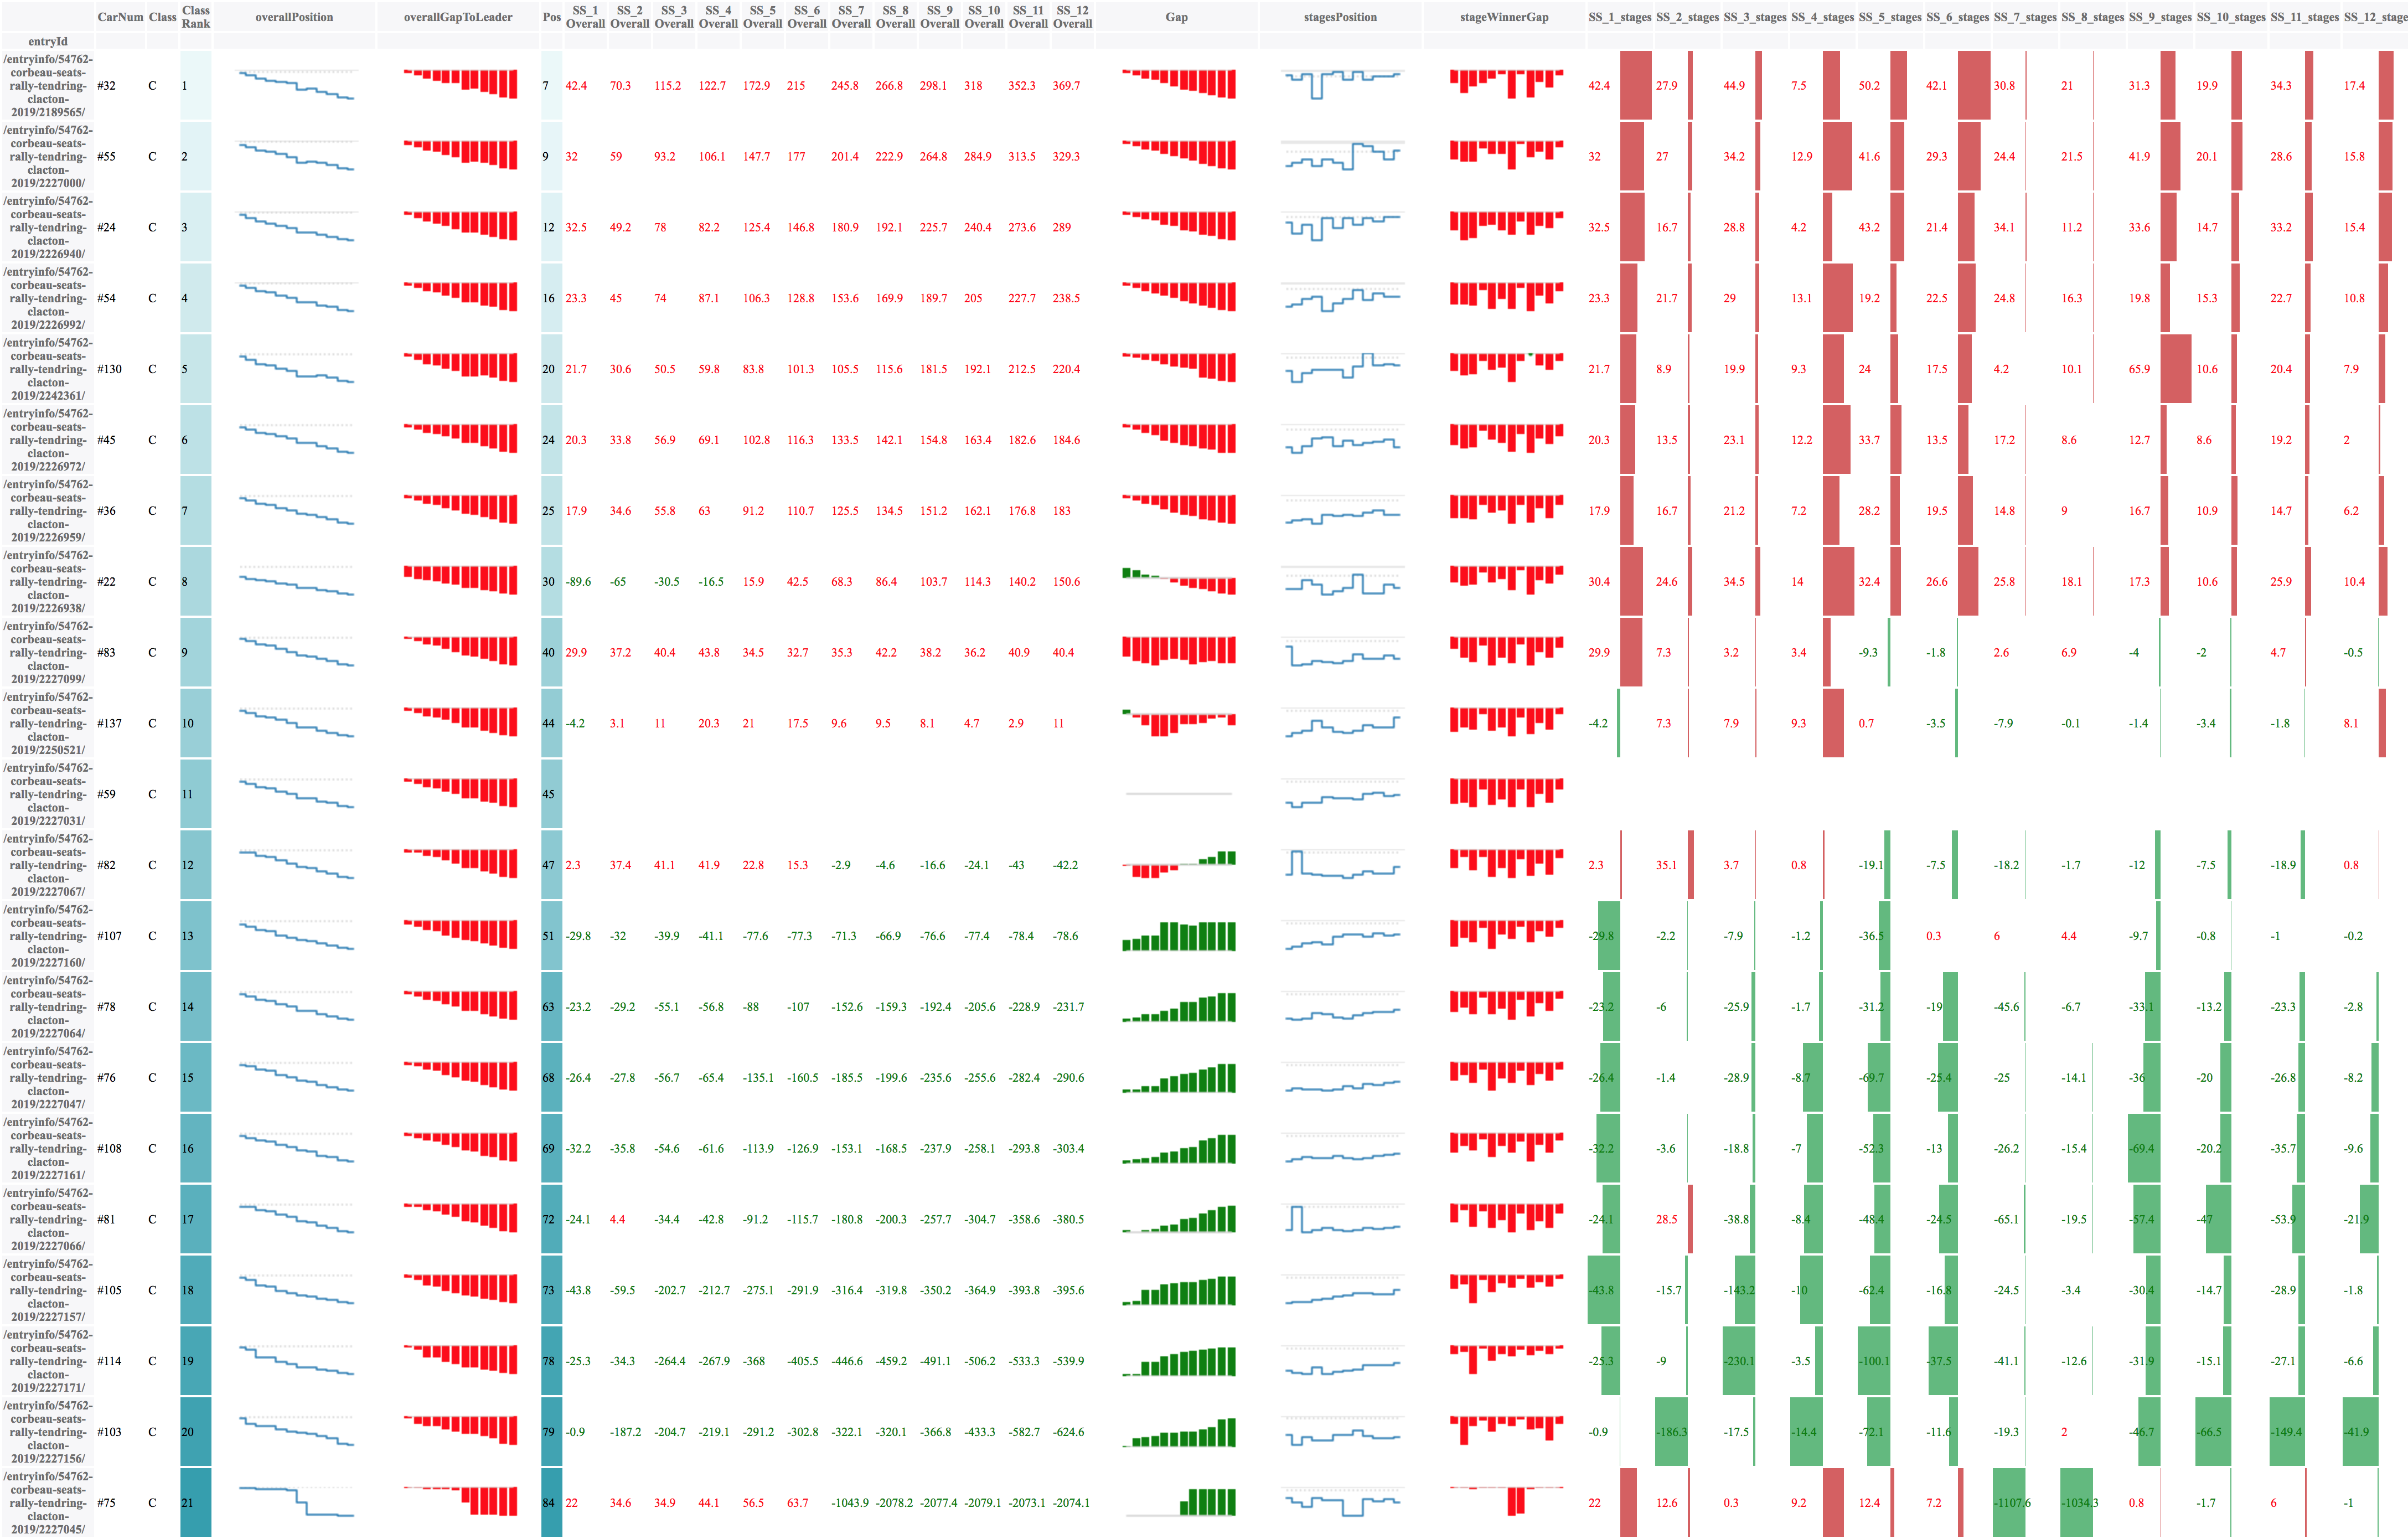

In [85]:
from IPython.display import Image
Image(_)

In [86]:
#TOP 20 overall
codes = pd.DataFrame(df_rally_overall[:20].index.tolist()).rename(columns={0:'entryId'}).set_index('entryId')
wREBASE=codes.iloc[7].name
print(wREBASE)
codes


/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189564/


""
entryId
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189561/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162347/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226943/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162362/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2162350/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2226888/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189565/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2189564/
/entryinfo/54762-corbeau-seats-rally-tendring-clacton-2019/2227000/


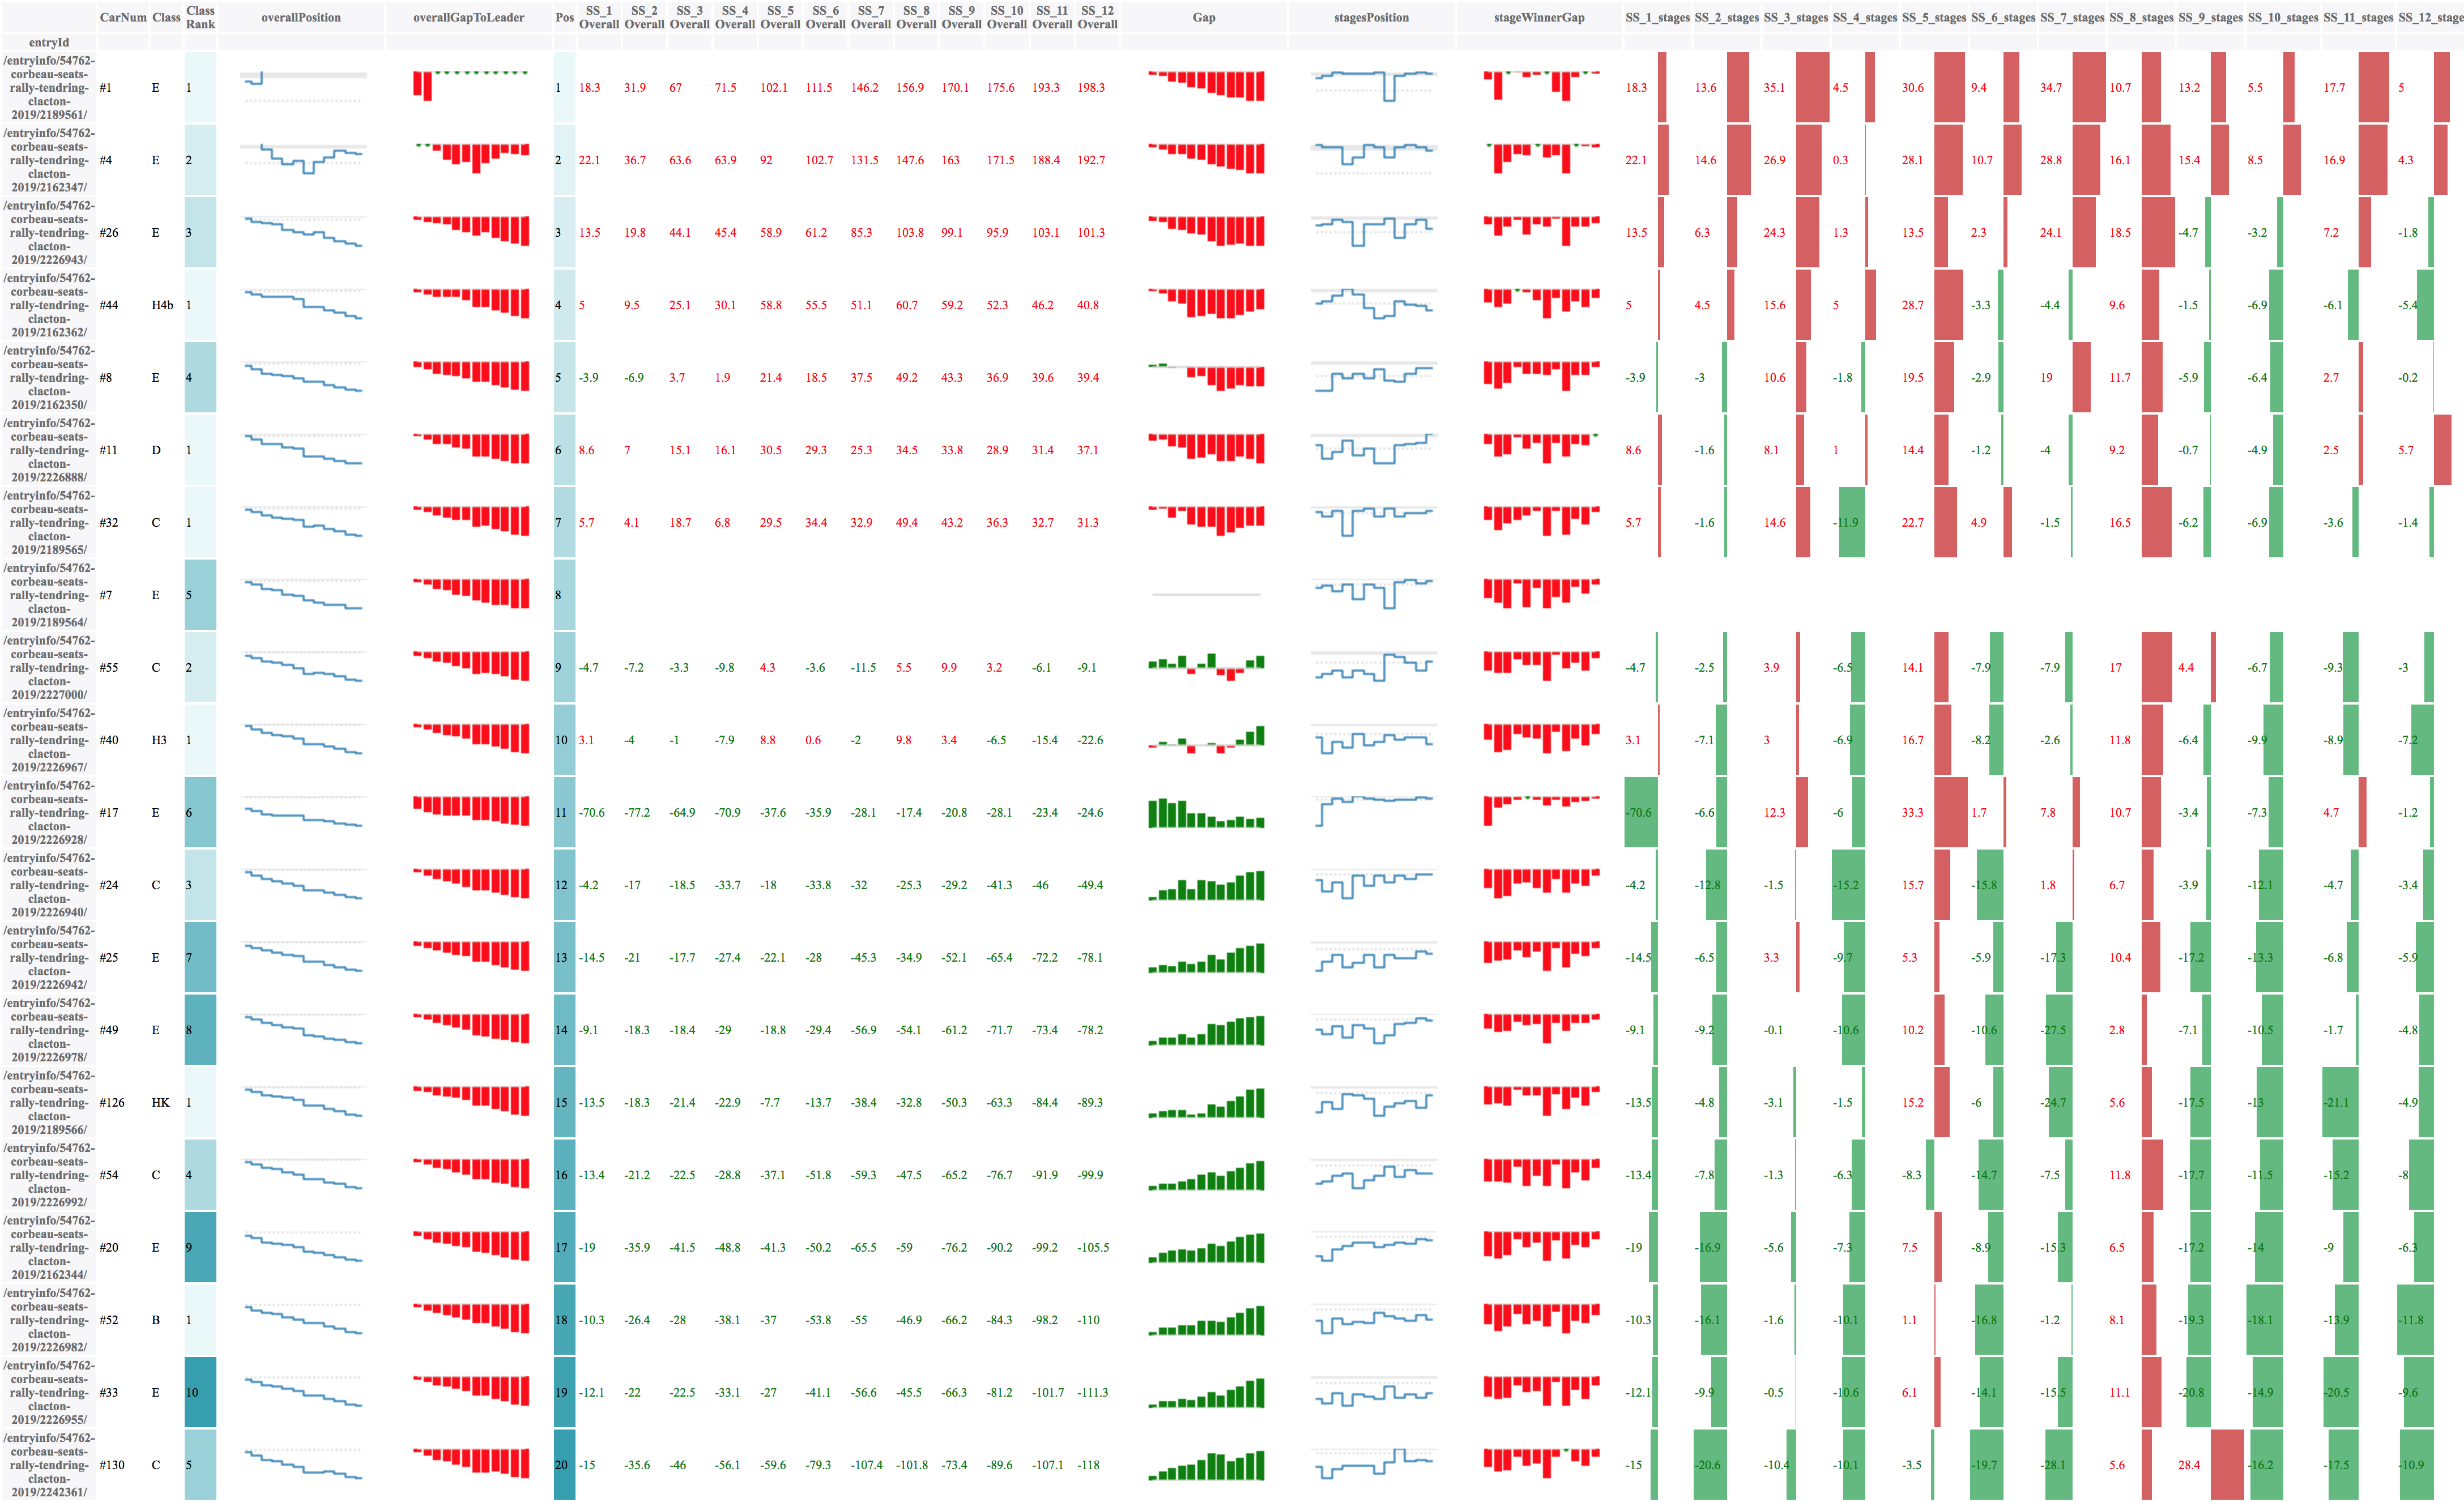

In [87]:
tmp, s2 = rally_report(codes, wREBASE)
_ = dakar.getTablePNG(s2, fnstub='overall_{}_'.format(wREBASE.replace('/','_')),scale_factor=2)
Image(_)

In [88]:
_

'testpng/overall__entryinfo_54762-corbeau-seats-rally-tendring-clacton-2019_2189564__.png'

## Widgets Example

In [91]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [92]:
import ipywidgets as widgets
from ipywidgets import interact

classes = widgets.Dropdown(
    options=['All']+df_rally_overall['Class'].unique().tolist(),
    value='All', description='Class:', disabled=False )

def carsInClass(qclass):
    #Can't we also pass a dict of key/vals to the widget?
    if qclass=='All':
        return df_rally_overall['CarNum'].to_list()
    return df_rally_overall[df_rally_overall['Class']==qclass]['CarNum'].to_list()

carNum = widgets.Dropdown(
    options=carsInClass(classes.value),
    description='Car:', disabled=False)

def update_drivers(*args):
    carlist = carsInClass(classes.value)
    carNum.options = carlist
    
classes.observe(update_drivers, 'value')

def rally_report2(cl, carNum):
    rebase = df_rally_overall[df_rally_overall['CarNum']==carNum].index[0]
    carNums = df_rally_overall[df_rally_overall['CarNum'].isin(carsInClass(cl))].index.tolist()
    codes = pd.DataFrame(carNums).rename(columns={0:'entryId'}).set_index('entryId')
    tmp, s2 = rally_report(codes, rebase)
    
    #display(HTML(s2))
    _ = dakar.getTablePNG(s2, fnstub='overall_{}_'.format(rebase.replace('/','_')),scale_factor=2)
    display(Image(_))
    print(_)
    
interact(rally_report2, cl=classes, carNum=carNum);

interactive(children=(Dropdown(description='Class:', options=('All', 'E', 'H4b', 'D', 'C', 'H3', 'HK', 'B', 'A…